<a href="https://colab.research.google.com/github/yy20190404/db_covid/blob/master/COVID19Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID19-Dashboard

## Collect COVID19 data from web

###　備忘録

herokuはPaaS（Platform as a Service）のひとつで、無料でプログラムを実行しwebに公開することができる。サーバー構築をしなくても公開できる。

herokuはGithubのリポジトリを利用しており、利用にあたってGithubのアカウントが必要。GitとHerokuをローカルPCにインストールし、CLIベースで利用するのが基本。

herokuは'git push heroku master'でプッシュされた際のファイルから自動的にファイルに合ったbuildpackをインストールする。Pythonの場合、'requirements.txt'があるとpythonと認識し、python buildpackageを使用する。

Gitコマンド：
・　リモートリポジトリの確認方法
  git config --get remote.origin.url
  git remote -v
  git remote show -n origin
  git remote show origin
  cat .git/config
  git config -l
  ((git remote show --help))
・　リモートリポジトリ追加
　git remote add origin username@ipaddress:/home/username/test.git
・　忘れがちなコマンド
　https://qiita.com/m_aki/items/3e0fbc0cf75eca96128b

Nginx：
　Buildpacのインストール必要　heroku dashborad settingsからインストールできる。
　https://github.com/heroku/heroku-buildpack-nginx

Gunicorn：
　pipでインストール可能。
　Dash（Flask）のapp定義の直下に'server = app.server'が必要。
　! gunicorn app:serverで起動
　http://127.0.0.1:8000


### install python libraries, make directories


In [ ]:
!python -m pip install --upgrade pip
!pip install requests
!pip install requests-html
!pip install seaborn
!pip install japanize-matplotlib
!pip install flask
!pip install plotly
!pip install dash
!pip install dash-html-components
!pip install dash-core-components
!pip install dash-table
!pip install dash-daq 
!pip install dash_bootstrap_components
!pip install gunicorn
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!mkdir templates
!mkdir static
!mkdir static/img
!mkdir static/csv
from google.colab import drive
drive.mount("/content/drive")
!cp drive/'My Drive'/'Colab Notebooks'/japan-map-master/japan-map.jquery.json templates/
!cp drive/'My Drive'/'Colab Notebooks'/japan-map-master/jquery.japan-map.js templates/
!cp drive/'My Drive'/'Colab Notebooks'/japan-map-master/jquery.japan-map.min.js templates/

### Reshape data to use dashboard

In [2]:
dldata = """

#!/usr/bin/env python
#-*- coding:utf-8 -*-

import datetime
import gc
import os
import sys

import numpy as np
import pandas as pd

import requests
from requests_html import HTMLSession

def get_converted_multi_columns(df, just_second=False, to_snake_case=True):
  if just_second:
    return [col[1] for col in df.columns.values]
  else:
    if to_snake_case:
        return [col[0] + '_' + col[1] for col in df.columns.values]
    else:
        return [col[0] + col[1].capitalize() for col in df.columns.values]

def down_load():
  HEADERS_DIC = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.97 Safari/537.36"}
  URLWW1 = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
  URLWW2 = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv"
  URLWW3 = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv"
  URLJP  = "https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv"
  SAVE_NAMES = ["covid19_ww_confirmed_global.csv", "covid19_ww_deaths_global.csv","covid19_ww_recovered_global.csv", "covid19_jp.csv"]
  DIRCSV = "./static/csv/"
  COMP_FILES = ["base_covid19_ww_confirmed_global.csv",
    "base_covid19_ww_deaths_global.csv",
    "base_covid19_ww_recovered_global.csv",
    "covid19_jp.csv",
    "covid19_jp_all.csv",
    "covid19_jp_prf_cfm.csv",
    "covid19_jp_prf_dth.csv",
    "covid19_jp_prf_female.csv",
    "covid19_jp_prf_gen.csv",
    "covid19_jp_prf_male.csv",
    "covid19_jp_prf_rcv.csv",
    "covid19_ww_confirmed_global.csv",
    "covid19_ww_deaths_global.csv",
    "covid19_ww_recovered_global.csv",
    "daily_covid19_jp_prf_cfm.csv",
    "daily_covid19_jp_prf_dth.csv",
    "daily_covid19_jp_prf_female.csv",
    "daily_covid19_jp_prf_male.csv",
    "daily_covid19_jp_prf_rcv.csv",
    "daily_covid19_ww_confirmed_global.csv",
    "daily_covid19_ww_deaths_global.csv",
    "daily_covid19_ww_recovered_global.csv"]
  urls = [URLWW1, URLWW2, URLWW3, URLJP]
  del_cols = ["Province/State", "Lat", "Long"]

  are_allfiles = True
  for x in COMP_FILES:
    if os.path.isfile(DIRCSV + x) == False: are_allfiles = False
  if are_allfiles:
    today = datetime.date.today()
    dt = os.path.getmtime(DIRCSV + COMP_FILES[16])
    dt = datetime.datetime.fromtimestamp(dt)
    dt = dt.strftime('%Y-%m-%d')
    if today == dt: return
  
  ##############################################################################
  ## Reshape of worldwide COVID19 daily numbers csv
  ##############################################################################
  today = datetime.date.today()
  save_names = SAVE_NAMES.copy()
  del save_names[-1]
  i = 0
  for f_name in save_names:
    # Download a target file if it is not exist
    if os.path.isfile(DIRCSV + f_name) == False:
      r = requests.get(urls[i], headers=HEADERS_DIC)
      with open(DIRCSV + 'base_' + f_name, mode='w', encoding='utf_8_sig') as f:
        f.write(r.text)

      ## Reshape csv file
      df = pd.read_csv(DIRCSV + 'base_' + f_name, encoding='utf_8_sig')
      ### Drop unnessesary columns
      df = df.drop(del_cols, axis=1) 
      ### Reshape date style          
      cols = df.columns
      dates = []
      for col in cols:
        if col == 'Country/Region':
          dates.append(col)
        else:
          day = datetime.datetime.strptime(col, '%m/%d/%y')  
          dates.append(day.strftime('%Y-%m-%d'))
      df.columns = dates
      ### Group and sum each country
      df = df.groupby("Country/Region").sum()
      ### Save as csv file
      df.to_csv(DIRCSV + f_name, encoding='utf_8_sig')
      ### Delete dataframe instance
      del df
    else:
      ### Get file datetime
      dt = os.path.getmtime(DIRCSV + f_name)
      dt = datetime.datetime.fromtimestamp(dt)
      dt = dt.strftime('%Y-%m-%d')
      ## Download and reshape csv file when the exist file not made on today
      if str(dt) != str(today):
        r = requests.get(urls[i], headers=HEADERS_DIC)
        with open(DIRCSV + 'base_' + f_name, mode='w', encoding='utf_8_sig') as f:
          f.write(r.text)
        df = pd.read_csv(DIRCSV + 'base_' + f_name, encoding='utf_8_sig')
        df = df.drop(del_cols, axis=1) 
        cols = df.columns
        if cols[0] != 'Country/Region':
          df = df.reset_index()
        dates = []
        for col in cols:
          if col == 'Country/Region':
            dates.append(col)
          else:
            day = datetime.datetime.strptime(col, '%m/%d/%y')  
            dates.append(day.strftime('%Y-%m-%d'))
        df.columns = dates
        ### Group and sum each countory
        df = df.groupby("Country/Region").sum()
        df = df.set_index('Country/Region')
        ### Save as csv file
        df.to_csv(DIRCSV + f_name, encoding='utf_8_sig')

        ### Delete dataframe instance
        del df
    i += 1
    ### Daily csv
    df = pd.read_csv(DIRCSV + f_name, encoding='utf_8_sig')
    df = df.set_index('Country/Region')
    for j in range(0, len(df.index), 1):
        for k in range(len(df.columns)-1, 0, -1):
          df.iloc[j, k] = df.iloc[j, k] - df.iloc[j, k-1]
    df.to_csv(DIRCSV + 'daily_' + f_name, encoding='utf_8_sig')
    del df
    

  ##############################################################################
  ## Reshape of Japanese COVID19 daily numbers csv
  ##############################################################################
  f_name = SAVE_NAMES[3]
  today = datetime.date.today()
  # Download a target file if it is not exist
  if os.path.isfile(DIRCSV + f_name) == False:
    r = requests.get(urls[3], headers=HEADERS_DIC)
    with open(DIRCSV + f_name, mode='w', encoding='utf_8_sig') as f:
      f.write(r.text)
  else:
    dt = os.path.getmtime(DIRCSV + f_name)
    dt = datetime.datetime.fromtimestamp(dt)
    dt = dt.strftime('%Y-%m-%d')
    if today != dt:
      r = requests.get(urls[3], headers=HEADERS_DIC)
      with open(DIRCSV + f_name, mode='w', encoding='utf_8_sig') as f:
        f.write(r.text)
    
  df = pd.read_csv(DIRCSV + f_name, encoding='utf_8_sig',
                   dtype={1: str, 3: str, 4: str, 23: str, 24: str, 25: str, 31: str, 32: str, 42: str, 43: str})
  ## Reshape csv file
  
  ################################################################################
  ## Download of Japanese COVID19 data
  ## Reshape the data
  ################################################################################
  df = df.loc[:, ["通し", "受診都道府県", "確定日", "更新日時", "年代", "性別", "ステータス", "人数"]]
  df.columns = ["No.", "Prefecture", "Date", "Saved_Date", "Genelation", "Sex", "Status", "Number"]
  df['Status'] = df['Status'].replace(np.nan, "confirmed")
  df['Status'] = df['Status'].replace('退院', "recovered")
  df['Status'] = df['Status'].replace('死(.*)', "death", regex=True)
  df['Prefecture'] = df['Prefecture'].replace('中部国際空港', '愛知県')
  df['Prefecture'] = df['Prefecture'].replace('成田空港', '千葉県')
  df['Prefecture'] = df['Prefecture'].replace('羽田空港', '東京都')
  df['Prefecture'] = df['Prefecture'].replace('関西国際空港', '大阪府')
  sr = df['Saved_Date']
  modified_date = str(sr[0])
  modified_date = datetime.datetime.strptime(modified_date, '%m/%d/%Y %H:%M')
  modified_date = modified_date.strftime('%Y-%m-%d %H:%M')
  df.at[0, 'Saved_Date'] = modified_date
  df = df.dropna(subset=["Date"])
  dates = []
  for date in df['Date']:
    day = datetime.datetime.strptime(str(date), '%m/%d/%Y')
    dates.append(day.strftime('%Y-%m-%d'))
  df['Date'] = dates

  df.to_csv(DIRCSV + "covid19_jp_all.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・日付別発症者数リスト
  dfc = df.drop(["No.", "Saved_Date", "Genelation", "Sex", "Status"], axis=1)
  dfc = dfc.groupby(["Prefecture", "Date"]).sum().unstack()
  dfc = dfc.replace(np.nan, 0.0)
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc.to_csv(DIRCSV + "daily_covid19_jp_prf_cfm.csv", encoding='utf_8_sig')
  # Daily
  for i in range(0, len(dfc.index), 1):
      for j in range(1, len(dfc.columns), 1):
        dfc.iloc[i, j] = int(dfc.iloc[i, j-1]) + int(dfc.iloc[i, j])
  dfc.to_csv(DIRCSV + "covid19_jp_prf_cfm.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・日付別死者数リスト
  dfc = df.drop(["No.", "Saved_Date", "Genelation", "Sex", "Number"], axis=1)
  dfc = dfc[dfc["Status"] != "confirmed"]
  dfc = dfc[dfc["Status"] != "recovered"]
  dfc["Status"] = 1
  dfc = dfc.groupby(["Prefecture", "Date"]).sum().unstack()
  dfc = dfc.replace(np.nan, 0.0)
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc.to_csv(DIRCSV + "daily_covid19_jp_prf_dth.csv", encoding='utf_8_sig')
  # Daily
  for i in range(0, len(dfc.index), 1):
      for j in range(1, len(dfc.columns), 1):
        dfc.iloc[i, j] = int(dfc.iloc[i, j-1]) + int(dfc.iloc[i, j])
  dfc.to_csv(DIRCSV + "covid19_jp_prf_dth.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・日付別退院者数リスト
  dfc = df.drop(["No.", "Saved_Date", "Genelation", "Sex", "Number"], axis=1)
  dfc = dfc[dfc["Status"] != "confirmed"]
  dfc = dfc[dfc["Status"] != "death"]
  dfc["Status"] = 1
  dfc = dfc.groupby(["Prefecture", "Date"]).sum().unstack()
  dfc = dfc.replace(np.nan, 0.0)
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc.to_csv(DIRCSV + "daily_covid19_jp_prf_rcv.csv", encoding='utf_8_sig')
  # Daily
  for i in range(0, len(dfc.index), 1):
      for j in range(1, len(dfc.columns), 1):
        dfc.iloc[i, j] = int(dfc.iloc[i, j-1]) + int(dfc.iloc[i, j])
  dfc.to_csv(DIRCSV + "covid19_jp_prf_rcv.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・ 男性数リスト
  dfc = df.drop(["No.", "Saved_Date", "Genelation", "Status", "Number"], axis=1)
  dfc = dfc[dfc["Sex"] != "女性"]
  dfc["Sex"] = 1
  dfc = dfc.groupby(["Prefecture", "Date"]).sum().unstack()
  dfc = dfc.replace(np.nan, 0.0)
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc.to_csv(DIRCSV + "daily_covid19_jp_prf_male.csv", encoding='utf_8_sig')
  # Daily
  for i in range(0, len(dfc.index), 1):
      for j in range(1, len(dfc.columns), 1):
        dfc.iloc[i, j] = int(dfc.iloc[i, j-1]) + int(dfc.iloc[i, j])
  dfc.to_csv(DIRCSV + "covid19_jp_prf_male.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・ 女性数リスト
  dfc = df.drop(["No.", "Saved_Date", "Genelation", "Status", "Number"], axis=1)
  dfc = dfc[dfc["Sex"] != "男性"]
  dfc["Sex"] = 1
  dfc = dfc.groupby(["Prefecture", "Date"]).sum().unstack()
  dfc = dfc.replace(np.nan, 0.0)
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc.to_csv(DIRCSV + "daily_covid19_jp_prf_female.csv", encoding='utf_8_sig')
  # Daily
  for i in range(0, len(dfc.index), 1):
      for j in range(1, len(dfc.columns), 1):
        dfc.iloc[i, j] = int(dfc.iloc[i, j-1]) + int(dfc.iloc[i, j])
  dfc.to_csv(DIRCSV + "covid19_jp_prf_female.csv", encoding='utf_8_sig')

  ## 日本の都道府県別・ 年代別リスト
  dfc = df.drop(["No.", "Date", "Saved_Date", "Sex", "Status"], axis=1)
  dfc = dfc.replace(np.nan, 99.0)
  dfc = dfc.replace("0-10", 1.0)
  dfc = dfc.replace("10", 10.0)
  dfc = dfc.replace("20", 20.0)
  dfc = dfc.replace("30", 30.0)
  dfc = dfc.replace("40", 40.0)
  dfc = dfc.replace("50", 50.0)
  dfc = dfc.replace("60", 60.0)
  dfc = dfc.replace("70", 70.0)
  dfc = dfc.replace("80", 80.0)
  dfc = dfc.replace("90", 90.0)
  dfc = dfc.replace(10, 10.0)
  dfc = dfc.replace(20, 20.0)
  dfc = dfc.replace(30, 30.0)
  dfc = dfc.replace(40, 40.0)
  dfc = dfc.replace(50, 50.0)
  dfc = dfc.replace(60, 60.0)
  dfc = dfc.replace(70, 70.0)
  dfc = dfc.replace(80, 80.0)
  dfc = dfc.replace(90, 90.0)
  dfc["Genelation"] = dfc["Genelation"].replace("不明", 99.0)
  dfc["Genelation"] = dfc["Genelation"].astype(int)
  dfc = dfc.groupby(["Prefecture", "Genelation"]).sum().unstack()
  dfc.columns = get_converted_multi_columns(dfc, just_second=True)
  dfc = dfc.replace(np.nan, 0.0)
  dfc = dfc.astype(int)
  dfc.to_csv(DIRCSV + "covid19_jp_prf_gen.csv", encoding='utf_8_sig')

if __name__ == "__main__":
  down_load()
"""

  
with open('dldata.py', mode='w', encoding='utf_8_sig') as f:
  f.write(dldata)

## Dashboard

### Build application server

### app.pyの作成

In [11]:
#dashfile = """
# -*- coding: utf-8 -*-
import os
import datetime
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import numpy as np
import pandas as pd
import dldata
import wmap
#import matplotlib



def make_xyz(df, col):
  df.loc[col] = df.sum()
  df_x = df.columns.tolist()
  df_y = df.loc[col, ].tolist()
  df_z = df.index.tolist()
  today_df = df_x[-1]
  today_number_df = df_y[-1]
  dicts = []
  for x in df_z:
    dicts.append({'label': x, 'value': x})
  return(df_x, df_y, dicts, today_df, today_number_df)

DIRCSV = 'static/csv/'
CSV_FILES = ('covid19_ww_confirmed_global.csv',
            'covid19_ww_deaths_global.csv',
            'covid19_ww_recovered_global.csv',
            'covid19_jp_prf_cfm.csv',
            'covid19_jp_prf_dth.csv',
            'covid19_jp_prf_rcv.csv',
            'covid19_jp_prf_male.csv',
            'covid19_jp_prf_female.csv',
            'covid19_jp_prf_gen.csv',
            'daily_covid19_ww_confirmed_global.csv',
            'daily_covid19_ww_deaths_global.csv',
            'daily_covid19_ww_recovered_global.csv',
            'daily_covid19_jp_prf_cfm.csv',
            'daily_covid19_jp_prf_dth.csv',
            'daily_covid19_jp_prf_rcv.csv',
            'daily_covid19_jp_prf_male.csv',
            'daily_covid19_jp_prf_female.csv')

df00 = pd.read_csv(DIRCSV + CSV_FILES[0], header=0, index_col=0)
df01 = pd.read_csv(DIRCSV + CSV_FILES[1], header=0, index_col=0)
df02 = pd.read_csv(DIRCSV + CSV_FILES[2], header=0, index_col=0)
df03 = pd.read_csv(DIRCSV + CSV_FILES[3], header=0, index_col=0)
df04 = pd.read_csv(DIRCSV + CSV_FILES[4], header=0, index_col=0)
df05 = pd.read_csv(DIRCSV + CSV_FILES[5], header=0, index_col=0)
df06 = pd.read_csv(DIRCSV + CSV_FILES[6], header=0, index_col=0)
df07 = pd.read_csv(DIRCSV + CSV_FILES[7], header=0, index_col=0)
df08 = pd.read_csv(DIRCSV + CSV_FILES[8], header=0, index_col=0)
df09 = pd.read_csv(DIRCSV + CSV_FILES[9], header=0, index_col=0)
df10 = pd.read_csv(DIRCSV + CSV_FILES[10], header=0, index_col=0)
df11 = pd.read_csv(DIRCSV + CSV_FILES[11], header=0, index_col=0)
df12 = pd.read_csv(DIRCSV + CSV_FILES[12], header=0, index_col=0)
df13 = pd.read_csv(DIRCSV + CSV_FILES[13], header=0, index_col=0)
df14 = pd.read_csv(DIRCSV + CSV_FILES[14], header=0, index_col=0)
df15 = pd.read_csv(DIRCSV + CSV_FILES[15], header=0, index_col=0)
df16 = pd.read_csv(DIRCSV + CSV_FILES[16], header=0, index_col=0)

df00_x, df00_y, dict00, today_df00, today_number_df00 = make_xyz(df00, 'Worldwide')
df01_x, df01_y, dict01, today_df01, today_number_df01 = make_xyz(df01, 'Worldwide')
df02_x, df02_y, dict02, today_df02, today_number_df02 = make_xyz(df02, 'Worldwide')
df03_x, df03_y, dict03, today_df03, today_number_df03 = make_xyz(df03, '全日本')
df04_x, df04_y, dict04, today_df04, today_number_df04 = make_xyz(df04, '全日本')
df05_x, df05_y, dict05, today_df05, today_number_df05 = make_xyz(df05, '全日本')
df06_x, df06_y, dict06, today_df06, today_number_df06 = make_xyz(df06, '全日本')
df07_x, df07_y, dict07, today_df07, today_number_df07 = make_xyz(df07, '全日本')
df08_x, df08_y, dict08, today_df08, today_number_df08 = make_xyz(df08, '全日本')
df09_x, df09_y, dict09, today_df09, today_number_df09 = make_xyz(df09, '全日本')
df10_x, df10_y, dict10, today_df10, today_number_df10 = make_xyz(df10, '全日本')
df11_x, df11_y, dict11, today_df11, today_number_df11 = make_xyz(df11, '全日本')
df12_x, df12_y, dict12, today_df12, today_number_df12 = make_xyz(df12, '全日本')
df13_x, df13_y, dict13, today_df13, today_number_df13 = make_xyz(df13, '全日本')
df14_x, df14_y, dict14, today_df14, today_number_df14 = make_xyz(df14, '全日本')
df15_x, df15_y, dict15, today_df15, today_number_df15 = make_xyz(df15, '全日本')
df16_x, df16_y, dict16, today_df16, today_number_df16 = make_xyz(df16, '全日本')

txt00 = str(today_df00) + '全世界COVID-19感染者総数：' + str(today_number_df00) + '名'
txt01 = str(today_df01) + '全世界COVID-19死者総数　：' + str(today_number_df01) + '名'
txt02 = str(today_df02) + '全世界COVID-19快復者総数：' + str(today_number_df02) + '名'

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
server = app.server

# 背景色と文字色の設定
colors = {
    'background': '#111111',
    'text': '#7FDBFF',
    'text01': '#111111'
}

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
  html.H1(
    children='COVID19ダッシュボード',
    style={'textAlign': 'center',
          'color': colors['text']
    }
  ),

  html.H6(
    children='COVID19ワールドワイド及び日本国内感染者数情報', 
    style={'textAlign': 'center',
      'color': colors['text']
    }
  ),

  html.Div([
    html.H6(
      children = txt00,
      style={'color': colors['text']}
    ),
    html.H6(
      children = txt01,
      style={'color': colors['text']}
    ),
    html.H6(
      children = txt02,
      style={'color': colors['text']}
    ),
  ],style={'width': '32%', 'display': 'inline-block'}),

  html.Div([
    dcc.Graph(
        id='world_map',
        figure=wmap.wMap()
    )
  ],style={'width': '68%', 'display': 'inline-block'}),


##
# Plot WW confirmed
##
  html.Div([
      dcc.Input(
        id = 'textarea00',
        value = 'COVID19感染者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'bg_color': colors['background'],
          'width': '100%'
          }
      ),

      dcc.Dropdown(
        id='my_ticker_symbol00',
        options=dict00,
        value='Worldwide',
      ),

      dcc.Graph(
          id='example-graph00',
          figure={
              'data':[
                {'x': df00_x, 'y': df00_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  },
              }
          }
      ),
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot WW deaths
##
    html.Div([
      dcc.Input(
        id = 'textarea01',
        value = 'COVID19死者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol01',
        options=dict01,
        value='Worldwide',
      ),

      dcc.Graph(
          id='example-graph01',
          figure={
              'data':[
                {'x': df01_x, 'y': df01_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot WW recovered
##
    html.Div([
      dcc.Input(
        id = 'textarea02',
        value = 'COVID19退院者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol02',
        options=dict02,
        value='Worldwide',
      ),

      dcc.Graph(
          id='example-graph02',
          figure={
              'data':[
                {'x': df02_x, 'y': df02_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan Confirmed
##
    html.Div([
      dcc.Input(
        id = 'textarea03',
        value = 'COVID19感染者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol03',
        options=dict03,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph03',
          figure={
              'data':[
                {'x': df03_x, 'y': df03_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan deaths
##
    html.Div([
      dcc.Input(
        id = 'textarea04',
        value = 'COVID19死者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol04',
        options=dict04,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph04',
          figure={
              'data':[
                {'x': df04_x, 'y': df04_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan recovered
##
    html.Div([
      dcc.Input(
        id = 'textarea05',
        value = 'COVID19退院者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol05',
        options=dict05,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph05',
          figure={
              'data':[
                {'x': df05_x, 'y': df05_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan male
##
    html.Div([
      dcc.Input(
        id = 'textarea06',
        value = 'COVID19男性感染者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol06',
        options=dict06,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph06',
          figure={
              'data':[
                {'x': df06_x, 'y': df06_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan female
##
    html.Div([
      dcc.Input(
        id = 'textarea07',
        value = 'COVID19女性感染者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol07',
        options=dict07,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph07',
          figure={
              'data':[
                {'x': df07_x, 'y': df07_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),
##
# Plot Japan generation
##
    html.Div([
      dcc.Input(
        id = 'textarea08',
        value = 'COVID19年代別感染者数情報',
        style={'textAlign': 'center',
          'color': colors['text01'],
          'width': '100%'}
      ),

      dcc.Dropdown(
        id='my_ticker_symbol08',
        options=dict08,
        value='全日本',
      ),

      dcc.Graph(
          id='example-graph08',
          figure={
              'data':[
                {'x': df08_x, 'y': df08_y}
              ],
              'layout': {
                  'plot_bgcolor': colors['background'],
                  'paper_bgcolor': colors['background'],
                  'font': {
                      'color': colors['text']
                  }
              }
          }
      )
    ],style={'width': '32%', 'display': 'inline-block'}),

])

###############################################################################
##
# Callback WW confirmed
##
@app.callback(
  Output('textarea00', 'value'),
  [Input('my_ticker_symbol00', 'value')]
)

def update_text(value):
  value = 'COVID-19感染者数情報:  ' + value
  return value

@app.callback(
  Output('example-graph00', 'figure'),
  [Input('my_ticker_symbol00', 'value')])

def update_graph(stock_ticker):
  df00_y = df00.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df00_x, 'y': df00_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback WW deaths
##
@app.callback(
  Output('textarea01', 'value'),
  [Input('my_ticker_symbol01', 'value')]
)

def update_text(value):
  value = 'COVID-19死者数情報:  ' + value
  return value

@app.callback(
  Output('example-graph01', 'figure'),
  [Input('my_ticker_symbol01', 'value')])

def update_graph(stock_ticker):
  df01_y = df01.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df01_x, 'y': df01_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback WW recovered
##
@app.callback(
  Output('textarea02', 'value'),
  [Input('my_ticker_symbol02', 'value')]
)

def update_text(text):
  value = str('COVID-19快復者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph02', 'figure'),
  [Input('my_ticker_symbol02', 'value')])

def update_graph(stock_ticker):
  df02_y = df02.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df02_x, 'y': df02_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP confirmed
##
@app.callback(
  Output('textarea03', 'value'),
  [Input('my_ticker_symbol03', 'value')]
)

def update_text(text):
  value = str('COVID-19感染者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph03', 'figure'),
  [Input('my_ticker_symbol03', 'value')])

def update_graph(stock_ticker):
  df03_y = df03.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df03_x, 'y': df03_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP deaths
##
@app.callback(
  Output('textarea04', 'value'),
  [Input('my_ticker_symbol04', 'value')]
)

def update_text(text):
  value = str('COVID-19死者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph04', 'figure'),
  [Input('my_ticker_symbol04', 'value')])

def update_graph(stock_ticker):
  df04_y = df04.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df04_x, 'y': df04_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP recovered
##
@app.callback(
  Output('textarea05', 'value'),
  [Input('my_ticker_symbol05', 'value')]
)

def update_text(text):
  value = str('COVID-19快復者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph05', 'figure'),
  [Input('my_ticker_symbol05', 'value')])

def update_graph(stock_ticker):
  df05_y = df05.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df05_x, 'y': df05_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP male
##
@app.callback(
  Output('textarea06', 'value'),
  [Input('my_ticker_symbol06', 'value')]
)

def update_text(text):
  value = str('COVID-19男性感染者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph06', 'figure'),
  [Input('my_ticker_symbol06', 'value')])

def update_graph(stock_ticker):
  df06_y = df06.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df06_x, 'y': df06_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP female
##
@app.callback(
  Output('textarea07', 'value'),
  [Input('my_ticker_symbol07', 'value')]
)

def update_text(text):
  value = str('COVID-19女性感染者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph07', 'figure'),
  [Input('my_ticker_symbol07', 'value')])

def update_graph(stock_ticker):
  df07_y = df07.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df07_x, 'y': df07_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

##
# Callback JP generation
##
@app.callback(
  Output('textarea08', 'value'),
  [Input('my_ticker_symbol08', 'value')]
)

def update_text(text):
  value = str('COVID-19年齢別感染者数情報:  ' + text)
  return value

@app.callback(
  Output('example-graph08', 'figure'),
  [Input('my_ticker_symbol08', 'value')])

def update_graph(stock_ticker):
  df08_y = df08.loc[stock_ticker, ].tolist()
  fig = {
    'data':[
      {'x': df08_x, 'y': df08_y}
    ],
    'layout': {
      'title': stock_ticker,
      'plot_bgcolor': colors['background'],
      'paper_bgcolor': colors['background'],
      'font': {'color': colors['text']}
    }
  }
  return fig

#if __name__ == '__main__':
  #app.run_server(debug=True)
"""

with open('app.py', mode='w', encoding='utf-8') as f:
  f.write(dashfile)

### ngrok tonneling through Colaboratory

#### World map

In [13]:
wmap="""
def wMap():
  import plotly.graph_objects as go
  import pandas as pd
  import numpy as np

  df0 = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
  df1 = pd.read_csv('./static/csv/covid19_ww_confirmed_global.csv')
  df1 = df1.replace('US', 'United States')
  df1 = df1.replace('Congo (Brazzaville)', 'Congo, Democratic Republic of the')
  df1 = df1.replace('Congo (Kinshasa)', 'Congo, Republic of the')
  df1 = df1.replace('Czechia', 'Czech Republic')

  df0 = df0.set_index('COUNTRY')
  df1 = df1.set_index('Country/Region')

  df = df0.join(df1)

  inds = df.index
  cols = df.columns
  col = cols[-1]
  title = 'COVID-19 Confirmed: ' + col
  df = df[['CODE', col]]
  df = df.replace(np.nan, 0)


  fig = go.Figure(data=go.Choropleth(
      locations = df['CODE'],
      z = df[col],
      text = inds,
      colorscale = 'Blues',
      autocolorscale=True,
      reversescale=False,
      marker_line_color='darkgray',
      marker_line_width=0.5,
      colorbar_tickprefix = '',
      colorbar_title = 'COVID-19<br>Confirmed',
  ))

  fig.update_layout(
      title_text=title,
      geo=dict(
          showframe=True,
          showcoastlines=True,
          projection_type='equirectangular'
      ),
  #    annotations = [dict(
  #        x=0.55,
  #        y=0.1,
  #        xref='paper',
  #        yref='paper',
  #        text='Source: <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
  #            CIA World Factbook</a>',
  #        showarrow = False
  #    )]

  )
  return fig
"""
#fig.show()

with open('wmap.py', mode='w', encoding='utf_8_sig') as f:
  f.write(wmap)

In [ ]:
import wmap
import matplotlib

figure = wmap.wMap()

figure.show()

#### Japan map

In [ ]:
data = """
// ---------------------------------------------------------------------------------------------------------------
/* data */
definition_of_allJapan = [
    {
        "code"       :0,
        "name"       :"日本",
        "english"    :"Japan",
        "color"      :"#a0a0a0",
        "prefectures":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]
    }
];
definition_of_prefectures = [

    {
        "code" : 1,
        "name" : "北海道",
        "path" : [
            {
                "coords" : [483,92,483,93,483,95,483,97,482,99,481,100,482,101,483,103,484,103,484,104,485,105,487,106,488,107,489,109,489,110,489,111,488,114,488,114,487,114,486,116,486,119,486,121,486,122,487,124,488,124,490,124,491,124,493,122,494,122,495,119,495,117,496,117,497,116,498,116,499,114,499,113,501,114,500,114,500,115,500,115,501,115,502,115,504,115,505,116,506,116,507,116,508,114,509,114,510,114,510,113,509,113,509,112,507,111,505,110,504,109,504,108,502,107,502,106,501,106,501,105,499,105,498,105,495,103,493,102,492,101,492,100,493,96,494,95,497,93,499,93,500,93,501,94,502,95,502,95,503,96,504,97,505,99,505,99,505,99,505,99,505,100,505,100,506,100,506,100,507,99,508,97,509,96,511,96,511,95,516,92,522,92,525,93,527,95,531,97,534,99,535,100,536,100,539,102,540,102,542,103,544,104,546,104,547,105,549,107,551,108,551,108,552,106,553,105,553,102,553,101,552,98,554,95,556,91,557,89,565,81,566,80,567,80,570,78,571,78,572,79,573,79,575,79,578,79,579,79,580,79,579,79,579,78,581,76,581,76,582,76,582,76,581,76,581,76,581,77,581,77,581,78,583,78,583,78,584,78,584,77,585,77,585,76,586,76,586,75,587,75,586,75,586,74,587,73,587,73,588,73,589,72,590,72,593,71,593,72,593,72,594,71,594,70,594,70,595,69,595,68,596,68,597,67,597,67,598,66,599,66,598,65,589,67,588,65,587,61,586,60,585,59,585,59,584,58,584,57,584,55,584,54,584,53,584,52,586,50,586,48,587,46,588,44,588,43,588,42,587,41,587,41,586,42,586,43,585,43,585,44,584,46,581,48,581,49,580,50,579,51,578,52,576,53,570,53,568,52,568,51,567,50,567,49,566,49,566,50,565,51,565,51,565,50,564,49,561,48,561,48,561,48,561,49,561,50,560,49,558,49,557,49,557,49,556,47,557,47,557,47,550,43,549,43,548,42,546,41,544,39,543,39,541,37,540,35,539,35,537,32,536,31,535,30,535,30,534,29,534,28,533,27,532,25,529,22,526,18,524,16,523,16,522,15,521,14,520,15,520,16,518,17,518,17,517,16,516,16,516,17,516,19,516,20,515,21,516,25,519,34,519,39,519,41,519,43,518,44,518,44,518,45,517,46,517,46,517,50,518,52,518,54,517,55,517,55,517,56,516,58,515,58,514,59,512,60,512,61,511,62,512,63,512,64,512,64,512,65,512,66,512,67,513,69,514,71,512,75,510,77,508,77,507,77,507,76,506,75,506,75,504,75,503,76,502,76,501,76,499,74,499,74,498,73,497,73,495,71,495,72,495,72,494,72,493,73,493,74,492,75,493,77,494,77,495,79,495,79,496,81,495,82,493,84,492,85,492,87,491,87,490,86,489,87,489,88,488,89,487,89,486,90,484,90,483,91,483,91,483,92,483,92]
            },{
                "name" : "礼文島",
                "coords" : [506,19,505,20,505,20,505,20,505,19,504,18,504,16,505,15,506,19,506,19]
            },{
                "name" : "利尻島",
                "coords" : [508,21,509,21,510,22,511,23,510,25,508,24,507,23,508,21,508,21]
            },{
                "name" : "奥尻島",
                "coords" : [477,102,477,103,476,104,476,106,475,107,474,105,474,103,475,103,475,103,476,102,477,102,477,102]
            },

            {
                "name" : "北方領土",
                "subpath" : [
                    {
                        "name" : "択捉島",
                        "coords" :  [645,2,647,1,649,1,650,2,649,3,649,3,649,4,649,6,647,7,644,8,643,9,643,9,643,9,641,11,639,12,638,13,638,13,636,16,635,18,632,19,631,19,631,19,630,19,629,18,628,19,629,20,628,22,627,23,625,25,623,28,622,30,621,31,620,31,619,33,618,34,617,35,616,34,616,33,617,32,617,31,616,30,617,29,617,30,618,31,618,30,618,29,619,29,620,29,620,28,621,27,621,26,620,26,619,26,619,25,620,24,621,25,622,24,622,23,622,23,623,22,624,20,625,19,626,18,626,16,628,16,629,15,630,13,631,12,632,10,631,9,632,7,633,7,634,9,635,10,639,9,641,8,642,6,642,6,642,6,644,3,645,2,645,2]
                    },{
                        "name" : "歯舞島",
                        "coords" : [606,61,605,63,604,62,604,61,605,60,606,61,606,61]
                    },{
                        "name" : "色丹島",
                        "coords" : [617,50,618,50,619,51,617,52,616,52,618,53,616,53,615,55,614,55,613,54,613,53,614,52,615,51,616,50,617,50,617,50]
                    },{
                        "name" : "国後島",
                        "coords" : [605,36,608,37,610,35,610,38,609,38,608,38,607,38,607,39,606,40,605,41,603,41,602,42,601,43,601,44,600,45,599,45,599,45,599,46,598,47,599,48,598,48,598,48,597,50,596,51,594,52,594,53,593,55,593,59,593,58,593,57,592,57,591,57,590,56,590,54,591,52,593,50,595,48,596,48,596,46,596,45,597,44,597,43,597,43,599,41,601,37,601,36,602,35,602,35,604,35,605,36,605,36]
                    }
                ]
            }
        ]
    },

    {
        "code" : 2,
        "name" : "青森県",
        "path" : [
            {
                "coords" : [514,125,515,124,516,124,516,125,515,128,515,142,517,147,518,148,519,148,520,149,521,150,521,151,521,151,521,151,519,152,518,153,517,153,516,153,514,154,514,154,513,154,511,155,509,156,507,157,506,157,506,155,506,154,506,152,506,152,505,152,504,150,503,150,503,151,502,151,501,152,500,152,499,152,498,152,495,151,495,150,493,150,493,151,493,151,489,152,488,151,487,151,486,151,486,152,486,152,485,150,485,148,484,147,484,148,483,147,484,146,485,145,485,144,487,142,488,142,489,143,490,142,491,142,492,138,492,136,493,135,493,135,493,136,494,135,494,135,495,135,493,135,493,134,493,134,493,133,491,133,490,132,491,132,492,132,493,130,493,130,493,129,494,129,495,130,496,130,497,130,499,131,499,134,500,139,501,141,503,140,504,138,504,138,503,137,504,135,506,136,506,137,507,138,507,138,509,139,511,138,511,135,512,132,511,129,510,128,510,128,510,128,509,130,506,131,504,131,502,132,502,131,502,129,503,124,504,123,504,122,504,121,505,121,506,122,509,123,510,124,512,126,514,125,514,125]
            }
        ]
    },

    {
        "code" : 3,
        "name" : "岩手県",
        "path" : [
            {
                "coords" : [521,151,521,151,519,152,518,153,517,153,516,153,514,154,514,154,513,154,511,155,509,156,507,157,506,157,504,160,504,164,504,166,505,167,503,167,503,167,503,168,504,169,504,169,503,170,503,171,503,171,504,172,503,174,502,175,502,175,502,176,501,177,501,179,500,180,501,181,501,182,501,183,503,185,503,185,503,186,503,186,502,187,502,188,503,189,503,189,503,190,503,192,503,192,503,192,503,192,503,192,504,193,506,193,507,194,509,194,510,194,510,195,510,196,511,197,512,197,512,197,512,198,514,196,515,196,515,196,516,197,517,197,517,196,518,193,518,192,518,191,521,192,521,191,521,191,522,191,522,192,523,192,523,192,524,191,523,190,523,189,526,190,525,189,527,189,526,188,525,188,526,188,527,188,527,188,527,187,526,186,527,186,527,185,527,185,528,184,528,184,527,184,527,183,528,183,527,182,528,182,529,181,528,181,527,181,528,180,528,180,528,179,529,179,529,179,530,177,530,177,529,177,527,177,529,176,530,176,530,175,529,174,529,173,529,172,529,172,528,173,528,170,528,168,528,166,527,165,527,164,527,163,527,162,526,162,526,162,526,161,524,160,525,159,525,159,525,158,524,157,524,157,524,156,523,153,522,151,521,151,521,151,521,151]
            }
        ]
    },

    {
        "code" : 4,
        "name" : "宮城県",
        "path" : [
            {
                "coords" : [518,192,518,191,521,192,521,191,522,195,521,193,520,195,521,196,519,196,519,197,519,197,520,199,520,199,520,199,519,199,519,199,517,200,518,201,519,201,519,202,518,203,519,204,519,203,520,204,520,205,519,205,519,205,519,205,519,206,519,206,518,207,519,207,520,207,519,208,519,208,519,208,520,210,519,210,518,210,518,210,518,209,517,209,517,208,517,208,516,208,513,207,512,208,512,210,510,210,510,209,511,209,510,208,509,209,509,209,509,210,509,210,510,210,510,210,509,211,507,213,507,222,506,222,505,222,505,223,505,224,504,225,503,225,504,225,502,225,501,223,499,222,497,222,496,222,496,221,496,220,495,220,494,220,494,220,492,220,492,220,492,220,492,219,492,219,492,218,493,218,495,217,495,216,496,215,496,214,496,212,497,210,497,210,498,210,498,209,499,208,499,206,499,205,498,204,498,201,499,201,499,201,499,200,500,198,499,196,498,195,498,194,500,194,501,193,502,193,503,192,503,192,503,192,503,192,504,193,506,193,507,194,509,194,510,194,510,195,510,196,511,197,512,197,512,197,512,198,514,196,515,196,515,196,516,197,517,197,517,196,518,193,518,192,518,192]
            }
        ]
    },

    {
        "code" : 5,
        "name" : "秋田県",
        "path" : [
            {
                "coords" : [506,152,506,154,506,155,506,157,504,160,504,164,504,166,505,167,503,167,503,167,503,168,504,169,504,169,503,170,503,171,503,171,504,172,503,174,502,175,502,175,502,176,501,177,501,179,500,180,501,181,501,182,501,183,503,185,503,185,503,186,503,186,502,187,502,188,503,189,503,189,503,190,503,192,503,192,503,192,503,192,502,193,501,193,500,194,498,194,498,194,497,194,496,193,495,192,495,192,494,191,494,191,494,190,493,190,493,191,491,190,491,190,490,189,489,190,488,189,487,188,487,188,485,188,484,188,484,188,484,187,484,186,484,186,484,185,484,184,485,183,486,181,487,170,486,168,485,166,486,166,487,167,487,165,486,165,486,165,485,164,485,162,486,161,485,163,485,164,485,166,483,167,482,167,481,167,480,166,480,163,481,164,482,165,485,161,486,156,486,153,485,152,485,152,486,152,486,152,486,151,487,151,488,151,489,152,493,151,493,151,493,150,495,150,495,151,498,152,499,152,500,152,501,152,502,151,503,151,503,150,504,150,505,152,506,152,506,152,506,152]
            }
        ]
    },

    {
        "code" : 6,
        "name" : "山形県",
        "path" : [
            {
                "coords" : [498,194,497,194,496,193,495,192,495,192,494,191,494,191,494,190,493,190,493,191,491,190,491,190,490,189,489,190,488,189,487,188,487,188,485,188,484,188,484,188,483,190,482,194,481,196,479,199,477,202,476,203,476,204,477,204,479,205,480,205,480,206,480,208,481,209,483,210,483,212,481,213,479,213,479,215,479,217,478,220,478,221,478,223,479,224,480,224,481,224,481,224,482,224,483,224,484,224,485,224,485,225,486,226,487,226,487,226,487,226,488,227,489,226,490,226,491,226,492,225,492,224,492,220,492,220,492,220,492,220,492,219,492,219,492,218,493,218,495,217,495,216,496,215,496,214,496,212,497,210,497,210,498,210,498,209,499,208,499,206,499,205,498,204,498,201,499,201,499,201,499,200,500,198,499,196,498,195,498,194,498,194,498,194]
            }
        ]
    },

    {
        "code" : 7,
        "name" : "福島県",
        "path" : [
            {
                "coords" : [504,225,505,224,505,223,505,222,506,222,507,222,508,226,508,228,509,230,509,235,509,241,509,242,508,244,508,247,508,249,507,249,506,249,505,250,504,251,503,251,501,251,500,250,499,249,499,251,498,252,497,253,496,253,494,252,492,249,491,247,491,247,490,246,490,246,489,245,484,243,482,245,480,246,477,247,474,248,473,249,472,250,469,249,469,247,469,245,469,243,468,242,467,240,468,239,469,238,469,237,469,236,469,235,471,235,472,234,473,233,474,233,476,234,476,232,476,230,476,229,477,229,478,228,478,227,479,226,480,225,480,224,480,224,481,224,481,224,482,224,483,224,484,224,485,224,485,225,486,226,487,226,487,226,487,226,488,227,489,226,490,226,491,226,492,225,492,224,492,220,492,220,494,220,494,220,495,220,496,220,496,221,496,222,497,222,499,222,501,223,502,225,504,225,503,225,504,225,504,225]
            }
        ]
    },

    {
        "code" : 8,
        "name" : "茨城県",
        "path" : [
            {
                "coords" : [503,255,502,257,501,261,500,262,500,264,500,265,500,266,499,268,499,269,500,275,501,277,502,277,502,278,503,279,504,281,505,283,505,283,504,283,503,281,501,280,500,279,499,278,498,278,497,279,496,278,495,279,494,279,494,279,493,280,491,280,489,280,489,280,488,280,484,277,482,275,481,273,481,274,480,273,479,270,479,270,482,268,483,267,484,266,485,266,485,265,487,265,487,265,488,264,488,264,489,264,490,265,490,264,491,262,491,261,491,261,491,258,491,257,492,256,492,255,492,254,492,253,492,252,492,249,492,249,494,252,496,253,497,253,498,252,499,251,499,249,500,250,501,251,503,251,504,251,504,253,503,255,503,255]
            }
        ]
    },

    {
        "code" : 9,
        "name" : "栃木県",
        "path" : [
            {
                "coords" : [489,245,490,246,490,246,491,247,491,247,492,249,492,249,492,252,492,253,492,254,492,255,492,256,491,257,491,258,491,261,491,261,491,262,490,264,490,265,489,264,488,264,488,264,487,265,487,265,485,265,485,266,484,266,483,267,482,268,479,270,479,270,478,269,477,268,475,268,473,267,472,266,472,263,472,262,473,261,474,260,473,259,471,258,471,256,471,255,471,254,472,253,472,252,472,252,472,250,472,250,473,249,474,248,477,247,480,246,482,245,484,243,489,245,489,245]
            }
        ]
    },

    {
        "code" : 10,
        "name" : "群馬県",
        "path" : [
            {
                "coords" : [467,248,468,249,469,249,472,250,472,250,472,250,472,252,472,252,472,253,471,254,471,255,471,256,471,258,473,259,474,260,473,261,472,262,472,263,472,266,473,267,475,268,477,268,478,269,479,270,477,270,475,270,474,270,471,269,471,269,470,269,467,268,465,270,464,271,464,272,464,272,463,272,462,273,462,273,461,273,459,274,457,275,456,276,456,276,455,276,454,273,455,273,454,272,453,270,454,271,454,270,454,269,454,268,454,267,455,267,454,264,453,264,451,264,449,263,450,260,450,259,451,258,451,257,452,257,452,256,452,256,456,255,456,255,457,254,457,254,458,255,459,253,460,253,460,252,462,252,462,250,463,251,463,248,465,247,465,246,466,246,467,248,467,248]
            }
        ]
    },

    {
        "code" : 11,
        "name" : "埼玉県",
        "path" : [
            {
                "coords" : [471,269,471,269,470,269,467,268,465,270,464,271,464,272,464,272,463,272,462,273,462,273,461,273,459,274,457,275,456,276,456,276,456,277,457,278,457,278,458,279,458,279,459,280,460,280,461,280,461,280,461,280,462,280,462,280,462,279,462,279,463,279,463,279,463,279,465,280,467,280,469,281,469,281,470,281,471,282,473,282,475,282,475,282,476,283,478,282,478,282,479,282,480,282,481,281,483,282,483,282,483,282,483,280,483,280,483,278,482,277,481,275,481,275,481,275,481,274,481,274,480,273,479,270,477,270,475,270,474,270,471,269,471,269]
            }
        ]
    },

    {
        "code" : 12,
        "name" : "千葉県",
        "path" : [
            {
                "coords" : [498,278,497,279,496,278,495,279,494,279,494,279,493,280,491,280,489,280,489,280,488,280,484,277,482,275,481,273,481,274,481,274,481,275,481,275,481,275,482,277,483,278,483,280,483,282,483,282,483,282,483,283,484,284,483,286,483,286,484,286,485,285,486,286,486,286,487,286,488,288,488,288,488,288,487,289,486,290,486,291,485,291,485,292,484,293,484,294,483,294,482,294,482,295,481,295,480,295,482,296,482,297,483,298,482,299,482,300,482,302,481,303,482,304,482,304,481,305,480,305,481,306,482,307,482,307,483,307,485,306,486,304,487,303,488,303,488,302,489,301,490,301,492,301,493,300,493,301,494,300,495,299,496,298,495,297,495,295,496,291,499,287,502,285,503,285,504,284,505,284,506,285,506,285,506,284,506,283,505,283,505,283,504,283,503,281,501,280,500,279,499,278,498,278,498,278]
            }
        ]
    },

    {
        "code" : 13,
        "name" : "東京都",
        "path" : [
            {
                "coords" : [481,281,483,282,483,283,484,284,483,286,483,286,483,286,483,286,483,286,482,286,481,286,481,287,481,289,480,289,479,289,479,289,479,289,478,288,476,287,475,286,475,287,474,287,473,287,474,287,474,288,474,288,474,288,474,289,474,290,473,290,470,287,466,285,466,285,466,285,466,285,466,285,465,285,462,282,461,280,461,280,462,280,462,280,462,279,462,279,463,279,463,279,463,279,465,280,467,280,469,281,469,281,470,281,471,282,473,282,475,282,475,282,476,283,478,282,478,282,479,282,480,282,481,281,481,281]
            },

            {
                "name" : " 伊豆諸島",
                "subpath" : [
                    {
                        "name" : "三宅島",
                        "coords" : [476,330,476,331,475,332,474,333,473,332,473,331,474,330,475,330,476,330,476,330]
                    },{
                        "name" : "御蔵島",
                        "coords" : [476,338,476,337,476,337,477,337,476,338,476,338]
                    },{
                        "name" : "八丈島",
                        "coords" : [481,358,482,359,482,360,482,361,482,362,482,361,481,361,480,360,480,359,481,358,481,358]
                    },{
                        "name" : "神津島",
                        "coords" : [465,326,466,326,466,327,466,328,465,328,465,326,465,326]
                    },{
                        "name" : "新島",
                        "coords" : [469,321,469,322,469,323,469,324,468,323,468,322,468,322,469,321,469,321]
                    },{
                        "name" : "大島",
                        "coords" : [472,311,473,312,473,313,471,313,470,311,472,311,472,311]
                    }
                ]
            }
        ]
    },

    {
        "code" : 14,
        "name" : "神奈川県",
        "path" : [
            {
                "coords" : [476,287,478,288,479,289,479,289,480,289,481,289,481,289,481,290,480,290,479,291,478,291,478,291,478,291,478,291,479,293,478,293,478,293,478,294,478,295,478,295,478,296,478,296,479,297,480,297,480,298,479,299,478,300,478,300,478,301,477,301,477,300,477,299,477,299,477,298,476,297,474,296,474,296,473,295,471,296,467,297,466,299,466,300,463,300,463,298,462,297,462,296,463,294,462,293,461,293,460,293,462,291,463,290,464,290,464,289,465,287,466,285,466,285,470,287,473,290,474,290,474,289,474,288,474,288,474,288,474,287,473,287,474,287,475,287,475,286,476,287,476,287]
            }
        ]
    },

    {
        "code" : 15,
        "name" : "新潟県",
        "path" : [
            {
                "coords" : [480,205,480,206,480,208,481,209,483,210,483,212,481,213,479,213,479,215,479,217,478,220,478,221,478,223,479,224,480,224,480,225,479,226,478,227,478,228,477,229,476,229,476,230,476,232,476,234,474,233,473,233,472,234,471,235,469,235,469,236,469,237,469,238,468,239,467,240,468,242,469,243,469,245,469,247,469,249,468,249,467,248,466,246,465,246,465,247,463,248,463,251,462,250,462,252,460,252,460,253,459,253,458,255,457,254,457,254,456,255,456,255,456,255,456,253,455,251,454,249,453,246,451,247,449,248,448,249,448,249,447,249,447,251,447,252,444,251,442,252,442,252,441,251,441,250,440,249,439,249,437,250,437,250,437,251,436,252,436,253,435,253,435,253,435,252,434,250,434,249,434,248,433,248,433,247,433,247,435,246,438,245,440,245,441,244,442,243,443,242,445,242,446,242,447,242,449,239,452,238,454,235,455,234,456,232,457,231,458,229,459,227,461,223,465,221,468,220,471,218,473,214,474,210,474,207,475,205,476,205,476,204,477,204,479,205,480,205,480,205]
            },{
                "name" : "佐渡島",
                "coords" : [452,211,452,210,453,210,453,211,453,213,452,216,453,217,454,217,454,217,454,219,450,223,449,224,448,224,447,224,446,224,447,223,448,223,448,222,448,221,449,220,449,219,449,219,448,219,448,220,447,220,447,218,447,217,448,216,448,214,449,213,451,212,452,211,452,211]
            }
        ]
    },

    {
        "code" : 16,
        "name" : "富山県",
        "path" : [
            {
                "coords" : [413,266,413,266,414,264,415,264,416,264,416,265,416,266,416,266,417,266,418,265,419,263,421,262,421,262,422,262,424,261,424,262,425,262,426,262,427,263,428,263,430,264,430,264,431,264,431,264,431,263,431,263,431,263,432,262,432,261,432,260,433,260,433,260,433,259,434,258,435,256,435,255,435,253,435,253,436,253,435,253,435,253,435,252,434,250,434,249,434,248,434,248,433,248,433,247,431,247,428,248,427,249,427,250,427,251,426,252,425,252,423,253,421,252,420,252,418,250,418,249,419,248,419,247,418,247,415,249,415,250,414,251,414,252,414,253,414,253,413,253,413,253,413,254,413,255,413,256,413,258,413,259,413,260,412,261,412,262,413,263,412,264,412,266,413,266,413,266,413,266]
            }
        ]
    },

    {
        "code" : 17,
        "name" : "石川県",
        "path" : [
            {
                "coords" : [424,236,425,236,425,236,423,238,422,238,420,239,419,240,418,240,417,240,417,240,416,241,416,242,415,243,415,244,416,245,416,243,417,244,418,244,418,243,419,243,419,244,419,245,419,247,419,247,419,247,418,247,415,249,415,250,414,251,414,252,414,253,413,253,413,253,413,254,413,255,413,256,413,258,413,259,413,260,412,261,412,262,413,263,412,264,412,266,413,266,413,266,413,266,413,266,413,266,413,267,413,267,412,270,411,271,411,271,410,272,409,271,408,270,406,270,405,269,405,269,404,270,403,269,402,268,401,266,400,265,400,265,401,264,403,263,405,260,407,258,409,255,410,254,411,252,412,248,412,247,413,246,412,244,412,242,411,241,412,238,412,237,413,236,414,235,415,235,415,234,416,234,417,234,417,234,421,233,421,232,423,232,425,231,427,232,427,234,426,234,425,234,424,236,424,236]
            },{
                "name" : "能登島",
                "coords" : [419,241,419,241,419,242,417,243,417,242,416,241,417,242,417,242,417,242,417,241,418,242,419,241,419,241]
            }
        ]
    },

    {
        "code" : 18,
        "name" : "福井県",
        "path" : [
            {
                "coords" : [401,266,402,268,403,269,404,270,405,269,405,269,406,270,408,270,409,271,410,272,411,271,410,273,410,276,412,276,412,278,411,279,409,280,408,280,408,279,403,280,401,280,400,281,400,282,400,282,399,283,398,282,397,282,397,283,396,285,395,286,394,286,393,287,391,287,390,289,389,290,388,290,386,291,384,290,381,289,381,288,380,288,380,287,380,286,380,285,381,284,381,285,381,285,381,285,381,285,381,286,383,286,385,285,385,286,384,287,385,287,387,287,386,286,386,286,386,284,387,284,389,286,388,285,389,284,389,285,389,284,389,283,389,283,388,283,389,282,389,283,390,284,390,283,391,284,392,283,392,282,392,281,392,281,393,280,394,280,394,281,394,282,394,282,395,282,395,280,394,277,393,276,393,275,393,274,393,274,393,273,395,270,397,268,397,266,399,265,400,265,400,265,401,266,401,266]
            }
        ]
    },

    {
        "code" : 19,
        "name" : "山梨県",
        "path" : [
            {
                "coords" : [460,280,459,280,458,279,458,279,457,278,457,278,457,278,456,279,455,279,454,279,453,278,451,278,450,278,450,277,449,277,447,277,446,279,445,279,444,281,444,282,444,282,443,283,443,284,444,285,444,285,444,285,444,285,445,287,445,288,445,291,445,294,445,295,446,295,447,295,448,296,448,298,449,299,450,299,451,298,451,296,452,292,453,293,454,293,455,293,455,294,455,294,457,294,461,293,461,293,460,293,462,291,463,290,464,290,464,289,465,287,466,285,466,285,465,285,462,282,461,280,460,280,460,280]
            }
        ]
    },

    {
        "code" : 20,
        "name" : "長野県",
        "path" : [
            {
                "coords" : [451,247,453,246,454,249,455,251,456,253,456,255,452,256,452,256,452,257,451,257,451,258,450,259,450,260,449,263,451,264,453,264,454,264,455,267,454,267,454,268,454,269,454,270,454,271,453,270,454,272,455,273,454,273,455,276,457,278,455,279,454,279,453,278,451,278,450,278,450,277,449,277,447,277,446,279,445,279,444,281,444,282,444,282,443,283,443,284,444,285,444,285,444,285,444,286,444,287,443,287,443,287,443,289,443,290,442,291,442,291,442,291,442,292,441,294,440,294,439,295,437,296,435,297,434,298,433,297,432,297,431,297,429,297,428,296,428,295,429,295,429,295,429,295,429,294,429,293,429,292,430,292,430,291,430,290,430,288,429,288,428,288,428,285,428,284,427,282,426,281,424,280,425,279,426,277,427,278,428,277,428,276,430,275,430,273,429,272,430,270,430,269,431,268,432,266,432,265,431,264,431,264,431,264,431,263,431,263,432,262,432,261,432,260,433,260,433,260,433,259,434,258,435,256,435,255,435,253,435,253,436,253,436,252,437,251,437,250,437,250,439,249,440,249,441,250,441,251,442,252,442,252,444,251,447,252,447,251,447,249,448,249,448,249,449,248,451,247,451,247]
            }
        ]
    },

    {
        "code" : 21,
        "name" : "岐阜県",
        "path" : [
            {
                "coords" : [425,262,424,262,424,261,422,262,421,262,419,263,418,265,417,266,416,266,416,266,416,265,416,264,415,264,414,264,413,266,413,266,413,266,413,267,413,267,413,267,412,270,411,271,411,271,410,273,410,276,412,276,412,278,411,279,409,280,408,280,408,279,403,280,401,280,400,281,400,282,400,282,399,283,399,284,400,285,401,287,402,286,402,287,402,290,401,293,402,296,402,295,402,296,403,295,404,295,405,296,406,297,407,298,408,299,408,299,408,298,408,296,408,295,408,295,409,293,411,292,414,291,415,291,415,291,416,292,417,293,418,294,419,295,420,295,421,295,423,295,424,296,425,296,426,297,427,296,429,295,429,295,429,295,429,294,429,293,429,292,430,292,430,291,430,290,430,288,429,288,428,288,428,285,428,284,427,282,426,281,424,280,425,279,426,277,427,278,428,277,428,276,430,275,430,273,429,272,430,270,430,269,431,268,432,266,432,265,431,264,431,264,430,264,430,264,428,263,427,263,426,262,425,262,425,262]
            }
        ]
    },

    {
        "code" : 22,
        "name" : "静岡県",
        "path" : [
            {
                "coords" : [454,293,453,293,452,292,451,296,451,298,450,299,449,299,448,298,448,296,447,295,446,295,445,295,445,294,445,291,445,288,444,285,444,285,444,285,444,285,444,286,444,287,443,287,443,287,443,289,443,290,442,291,442,291,442,291,442,292,441,294,440,294,439,295,437,296,435,297,434,298,434,299,435,299,434,300,434,300,433,301,433,301,432,302,431,304,430,305,430,306,429,307,428,308,427,308,426,310,426,313,426,313,426,313,428,313,428,312,428,310,428,309,428,311,429,310,430,309,429,310,429,312,430,311,429,312,429,313,430,313,432,314,434,314,440,314,444,316,444,315,443,314,444,312,445,311,446,310,447,308,448,307,449,306,450,305,451,305,451,304,451,304,451,304,451,303,451,303,452,302,454,301,456,301,459,302,459,304,458,304,457,304,457,307,457,309,456,310,457,311,456,311,456,312,456,313,456,313,457,314,457,315,458,316,459,316,461,314,462,314,462,314,463,312,464,311,464,310,465,309,466,308,466,306,465,305,465,305,465,304,464,303,465,301,463,300,463,298,462,297,462,296,463,294,462,293,461,293,461,293,457,294,455,294,455,294,455,293,454,293,454,293]
            }
        ]
    },

    {
        "code" : 23,
        "name" : "愛知県",
        "path" : [
            {
                "coords" : [429,297,431,297,432,297,433,297,434,298,435,297,434,298,434,299,435,299,434,300,434,300,433,301,433,301,433,301,432,302,431,304,430,305,430,306,429,307,428,308,427,308,426,310,426,312,426,313,426,313,426,313,426,313,419,315,415,315,416,313,417,313,418,313,420,312,421,312,422,311,422,311,422,312,422,312,422,312,422,311,422,311,422,309,421,309,420,309,419,309,419,310,418,309,416,309,415,309,414,308,414,307,414,305,413,306,413,308,414,310,414,312,411,310,411,309,412,308,411,306,411,304,412,302,412,301,411,302,411,302,411,301,410,301,409,301,409,301,409,300,408,299,408,299,408,299,408,298,408,296,408,295,408,295,409,293,411,292,414,291,415,291,415,291,416,292,417,293,418,294,419,295,420,295,421,295,423,295,424,296,425,296,426,297,427,296,429,295,428,295,428,296,429,297,429,297]
            }
        ]
    },

    {
        "code" : 24,
        "name" : "三重県",
        "path" : [
            {
                "coords" : [409,302,408,301,408,302,408,302,407,303,407,304,406,306,405,308,404,310,404,311,404,312,404,313,406,315,409,316,411,317,412,319,413,319,412,320,412,320,412,321,411,321,412,321,412,321,412,322,411,323,412,323,411,324,408,324,408,323,409,323,408,323,409,323,408,323,407,323,407,322,406,322,406,322,406,323,405,323,405,324,404,324,404,323,403,324,403,323,402,323,402,326,401,324,401,324,401,325,398,325,397,326,397,326,396,326,397,327,397,328,397,329,396,328,395,329,395,329,396,329,396,330,397,330,396,330,396,330,396,332,395,332,395,333,394,332,394,332,394,334,394,333,393,333,393,334,392,334,391,335,390,337,389,338,388,338,388,338,386,335,386,334,387,332,387,332,388,332,388,332,389,332,389,331,389,331,390,330,391,329,392,330,393,330,392,329,392,328,392,328,392,326,392,325,393,323,393,322,393,322,393,321,392,319,394,318,396,317,395,316,393,314,392,313,393,312,392,311,392,311,393,311,392,310,393,309,392,309,392,308,392,307,393,307,394,305,393,305,393,305,395,305,396,305,397,306,398,305,400,304,401,301,402,298,402,296,402,296,402,295,402,296,403,295,404,295,405,296,406,297,407,298,408,299,408,299,408,299,409,300,409,301,409,301,409,301,409,302,409,302]
            }
        ]
    },

    {
        "code" : 25,
        "name" : "滋賀県",
        "path" : [
            {
                "coords" : [396,282,397,282,397,282,397,282,397,282,397,282,397,282,399,282,399,282,399,283,399,283,399,283,399,284,400,285,401,287,402,286,402,287,402,290,401,293,402,296,402,296,402,298,401,301,400,304,398,305,397,306,396,305,395,305,393,305,393,305,394,305,393,307,392,307,392,308,391,307,392,307,391,306,390,305,390,305,389,305,388,303,388,302,387,299,388,296,388,295,388,293,386,291,388,290,389,290,390,289,391,287,393,287,394,286,395,286,396,285,397,283,396,282,396,282,396,282,396,282]
            }
        ]
    },

    {
        "code" : 26,
        "name" : "京都府",
        "path" : [
            {
                "coords" : [380,286,380,287,380,288,381,288,381,289,384,290,386,291,386,291,388,293,388,295,388,296,387,299,388,302,388,303,389,305,390,305,390,305,391,306,392,307,391,307,392,308,392,309,391,309,389,308,389,309,387,309,386,309,385,307,385,307,384,305,383,303,382,302,382,302,381,302,381,303,380,302,380,301,379,301,378,300,377,300,377,299,377,299,378,298,377,297,377,296,375,296,375,295,374,295,373,295,373,295,373,294,373,294,372,293,371,293,370,293,368,291,367,289,369,288,370,288,370,286,371,284,369,284,368,285,367,283,367,282,367,281,367,280,368,281,369,280,371,279,372,279,372,278,374,278,375,278,376,278,377,280,377,281,376,281,375,283,375,283,376,284,375,285,376,285,377,286,377,286,378,286,378,286,377,285,378,284,378,284,380,283,381,284,380,285,380,286,380,286]
            }
        ]
    },

    {
        "code" : 27,
        "name" : "大阪府",
        "path" : [
            {
                "coords" : [382,302,381,302,381,303,380,302,380,301,379,301,378,300,377,300,377,299,377,299,376,299,377,300,376,301,376,301,377,302,378,302,379,302,378,303,378,306,378,308,378,308,377,309,377,309,377,309,377,311,377,311,377,311,377,312,376,313,377,314,376,315,374,316,373,318,372,319,370,319,369,319,369,319,369,320,369,320,370,321,371,321,372,320,372,320,372,320,372,320,373,320,373,320,375,319,377,319,378,319,379,319,381,319,382,319,382,318,383,317,383,315,383,312,383,310,384,307,385,307,385,307,384,305,383,303,382,302,382,302,382,302]
            }
        ]
    },

    {
        "code" : 28,
        "name" : "兵庫県",
        "path" : [
            {
                "coords" : [367,282,367,283,368,285,369,284,371,284,370,286,370,288,369,288,367,289,368,291,370,293,371,293,372,293,373,294,373,294,373,295,373,295,374,295,375,295,375,296,377,296,377,297,378,298,377,299,376,299,377,300,376,301,376,301,377,302,378,302,379,302,378,303,378,306,378,308,377,309,377,309,376,309,375,308,375,309,373,309,372,309,371,310,367,310,365,308,363,307,362,306,360,305,359,306,359,305,358,305,356,305,355,305,355,305,355,306,354,306,353,306,352,306,351,306,351,305,351,305,351,303,350,302,351,301,351,300,351,300,351,299,351,298,352,297,353,294,354,294,354,293,355,291,356,291,357,291,357,290,357,288,357,288,357,287,356,286,356,285,356,282,356,281,356,280,358,280,359,280,360,280,360,280,361,280,362,280,363,280,363,280,364,280,365,280,367,281,367,282,367,282]
            },{
                "name" : "淡路島",
                "coords" : [368,312,367,312,367,312,367,313,365,315,364,317,365,319,365,319,365,320,364,321,362,321,361,322,360,323,360,322,359,322,359,321,359,321,359,321,358,321,358,320,359,320,358,320,359,319,359,318,360,318,361,316,362,315,363,314,366,312,368,312,368,312]
            }
        ]
    },

    {
        "code" : 29,
        "name" : "奈良県",
        "path" : [
            {
                "coords" : [389,308,389,309,387,309,386,309,385,307,384,307,383,310,383,312,383,315,383,317,382,318,382,319,382,321,383,322,383,323,383,323,382,323,381,324,380,325,380,326,379,326,379,327,380,328,380,330,380,331,380,332,380,333,380,333,380,334,382,333,383,333,384,333,386,334,386,334,386,335,386,334,387,332,389,331,390,330,391,329,392,330,393,330,392,329,392,328,392,328,392,326,392,325,393,323,393,322,393,322,393,321,392,319,394,318,396,317,395,316,393,314,392,313,393,312,392,311,392,311,393,311,392,310,393,309,392,309,391,309,389,308,389,308]
            }
        ]
    },

    {
        "code" : 30,
        "name" : "和歌山県",
        "path" : [
            {
                "coords" : [381,319,382,319,382,321,383,322,383,323,383,323,382,323,381,324,380,325,380,326,379,326,379,327,380,328,380,330,380,331,380,332,380,333,380,333,380,334,382,333,383,333,384,333,386,334,386,334,386,335,388,338,388,338,389,338,389,338,390,338,388,339,388,340,389,341,388,340,387,341,388,341,388,341,388,341,387,342,388,342,388,342,387,343,387,343,387,343,386,344,385,344,383,345,384,345,385,345,384,346,383,345,382,346,383,345,383,345,382,345,380,345,379,344,377,344,377,343,376,343,374,341,374,340,374,340,373,339,373,338,373,338,374,338,374,338,374,337,373,336,372,336,371,335,370,334,369,333,369,332,368,332,367,332,367,331,367,331,367,330,367,329,368,329,369,329,369,328,369,327,367,326,368,326,368,326,369,325,370,325,371,324,370,323,369,322,368,321,368,320,369,319,369,320,370,321,371,321,372,320,372,320,372,320,373,320,373,320,375,319,377,319,378,319,379,319,381,319,381,319]
            }
        ]
    },

    {
        "code" : 31,
        "name" : "鳥取県",
        "path" : [
            {
                "coords" : [348,282,352,282,354,281,356,280,356,281,356,282,356,285,356,286,357,287,357,288,357,288,357,290,357,291,356,291,355,291,354,291,353,292,352,292,350,293,349,292,349,291,348,290,348,289,347,289,346,288,346,288,346,287,344,288,342,289,341,290,341,289,341,288,338,287,337,287,336,288,335,289,334,289,334,291,333,291,332,291,331,291,329,293,328,293,328,294,327,294,326,293,324,292,325,292,326,291,326,290,326,289,326,289,327,288,329,288,329,287,330,285,330,285,330,284,330,283,329,283,328,281,328,280,329,280,329,281,331,282,332,283,333,282,338,281,340,282,342,282,346,282,346,282,347,282,348,282,348,282]
            }
        ]
    },

    {
        "code" : 32,
        "name" : "島根県",
        "path" : [
            {
                "coords" : [315,281,317,281,316,280,316,280,318,280,322,280,322,279,322,279,324,279,324,278,323,277,325,278,325,277,327,278,328,278,330,279,331,279,331,279,329,280,328,280,328,281,329,283,330,283,330,284,330,285,330,285,329,287,329,288,327,288,326,289,326,289,326,290,326,291,325,292,324,292,324,292,323,293,322,292,321,292,321,292,320,292,319,292,318,292,318,293,317,293,316,294,315,295,314,295,313,296,313,297,314,297,313,298,311,298,310,299,309,299,308,298,308,298,305,299,303,298,302,299,299,300,300,301,300,302,299,303,298,305,297,306,297,307,296,307,295,309,294,311,294,311,293,310,291,311,290,310,290,309,290,308,290,308,290,307,289,307,288,305,288,304,289,303,290,302,289,300,291,300,293,299,294,298,294,297,295,297,296,297,296,296,297,296,297,296,298,295,298,295,299,294,300,293,301,292,303,292,305,291,306,290,307,288,309,287,311,286,313,285,315,284,315,282,314,282,314,282,315,281,315,281]
            },{
                "name" : "隠岐島",
                "coords" : [333,257,334,258,335,259,334,261,333,262,332,262,330,261,330,259,331,258,333,257,333,257]
            },{
                "name" : "西ノ島",
                "coords" : [327,266,326,267,326,267,326,266,326,266,325,266,325,265,324,263,325,263,325,264,325,265,326,265,327,266,327,266]
            },{
                "name" : "中ノ島",
                "coords" : [329,264,328,264,329,265,328,264,328,265,327,266,327,264,327,263,326,264,326,264,326,262,328,262,327,263,327,263,328,263,328,263,329,264,329,264]
            }
        ]
    },

    {
        "code" : 33,
        "name" : "岡山県",
        "path" : [
            {
                "coords" : [346,287,346,288,346,288,347,289,348,289,348,290,349,291,349,292,350,293,352,292,353,292,354,291,354,293,354,294,353,294,352,297,351,298,351,299,351,300,351,300,351,301,350,302,351,303,351,305,351,305,350,306,347,309,346,309,345,309,345,309,345,308,344,309,343,308,343,309,344,309,344,310,344,311,344,310,344,311,344,313,343,311,343,311,342,312,341,313,340,312,339,312,339,313,339,313,338,312,337,311,337,312,336,312,336,311,336,310,336,310,335,310,335,310,335,311,334,311,334,311,333,311,332,311,332,310,331,310,331,311,331,311,330,311,330,310,330,310,330,309,330,308,329,306,329,305,329,303,329,301,328,300,328,298,328,297,328,296,329,296,328,295,328,294,328,293,329,293,331,291,332,291,333,291,334,291,334,289,335,289,336,288,337,287,338,287,341,288,341,289,341,290,342,289,344,288,346,287,346,287]
            }
        ]
    },

    {
        "code" : 34,
        "name" : "広島県",
        "path" : [
            {
                "coords" : [324,292,324,292,323,293,322,292,321,292,321,292,320,292,319,292,318,292,318,293,317,293,316,294,315,295,314,295,313,296,313,297,314,297,313,298,311,298,310,299,309,299,308,298,308,298,305,299,303,298,302,299,299,300,300,301,300,302,299,303,298,305,297,306,297,307,297,307,297,309,297,310,298,312,300,315,300,315,300,315,300,315,300,315,300,314,301,313,302,313,301,314,301,314,302,314,303,314,303,313,304,313,303,312,303,312,303,311,304,311,304,311,306,311,306,312,307,312,308,312,307,312,307,313,307,315,308,315,308,315,307,316,306,317,307,315,306,313,305,314,305,314,304,314,304,315,305,316,305,316,305,318,306,318,305,318,305,319,306,319,307,319,307,320,307,320,308,320,308,319,308,318,308,318,307,318,307,318,308,318,307,317,308,316,309,316,310,316,310,317,311,317,311,317,311,317,312,318,312,318,313,318,313,318,314,317,313,317,313,317,311,316,312,316,313,315,313,315,314,314,315,314,315,314,316,314,317,314,319,314,321,313,321,312,323,312,324,312,323,313,322,314,322,314,321,316,321,316,323,315,323,315,323,315,323,316,324,315,324,314,323,314,325,313,327,313,326,314,325,314,327,314,328,314,328,313,329,312,329,311,329,311,330,311,330,310,330,310,330,309,330,308,329,306,329,305,329,303,329,301,328,300,328,298,328,297,328,296,329,296,328,295,328,294,327,294,326,293,324,292,324,292]
            },{
                "name" : "大崎上島",
                "coords" : [315,315,317,315,317,314,317,315,317,316,316,317,315,317,315,316,315,315,315,315]
            }
        ]
    },

    {
        "code" : 35,
        "name" : "山口県",
        "path" : [
            {
                "coords" : [287,301,287,300,288,300,289,300,289,300,289,300,290,302,289,303,288,304,288,305,289,307,290,307,290,308,290,308,290,309,290,310,291,311,293,310,294,311,294,311,295,309,296,307,297,307,297,307,297,309,297,310,298,312,300,315,300,315,300,315,300,315,300,317,300,317,300,317,299,319,299,321,299,322,299,322,300,322,301,323,302,324,302,324,302,323,304,323,304,324,303,324,302,325,302,325,301,325,300,324,299,325,298,325,298,325,298,324,298,323,298,323,298,322,297,322,297,324,297,325,296,325,296,325,296,324,295,323,293,323,293,322,292,321,290,320,290,320,290,321,289,320,288,320,289,319,290,319,289,318,288,317,286,318,286,318,285,318,284,318,284,317,283,319,282,318,282,317,281,318,280,318,279,318,279,319,279,318,279,317,278,319,276,319,276,321,276,320,275,319,274,319,274,318,274,318,274,318,274,317,273,317,272,316,271,315,271,316,269,317,268,318,267,319,267,318,268,317,268,316,268,315,267,313,268,312,269,310,269,308,269,307,269,306,270,306,271,306,272,305,271,305,270,305,271,305,272,304,275,305,275,305,275,306,276,306,277,306,277,306,278,306,279,306,280,306,280,306,281,306,281,306,281,305,282,305,282,304,284,303,285,302,286,301,286,301,287,301,287,301]
            },{
                "name" : "長島",
                "coords" : [295,325,295,325,295,326,294,326,295,325,295,325,295,325]
            }
        ]
    },

    {
        "code" : 36,
        "name" : "徳島県",
        "path" : [
            {
                "coords" : [346,322,345,323,344,323,344,323,342,324,341,324,341,323,340,322,339,323,338,323,337,323,336,324,335,324,334,325,334,325,334,325,334,326,334,327,334,327,334,328,333,329,336,330,337,330,338,330,338,331,339,332,340,331,341,331,342,331,342,335,343,335,344,336,345,337,344,338,345,339,347,340,348,340,348,339,348,339,349,339,350,338,350,337,350,337,351,337,352,336,354,336,355,334,356,334,358,333,359,332,359,332,358,332,357,332,357,331,358,330,357,326,356,327,356,326,356,325,357,323,358,321,358,320,357,320,356,320,356,321,353,321,353,322,352,322,351,322,348,322,346,322,346,322]
            }
        ]
    },

    {
        "code" : 37,
        "name" : "香川県",
        "path" : [
            {
                "coords" : [347,315,347,315,347,316,347,317,347,316,348,316,348,316,348,316,348,317,349,317,349,317,349,318,349,319,350,319,351,319,351,320,352,319,352,320,353,321,353,321,353,321,353,321,353,322,352,322,351,322,348,322,346,322,345,323,344,323,344,323,342,324,341,324,341,323,340,323,340,322,339,323,338,323,337,323,336,324,335,324,334,325,334,325,334,325,334,325,333,324,332,324,333,323,333,322,334,320,333,318,332,317,333,317,334,318,335,318,336,318,337,317,338,316,339,315,339,315,340,316,340,315,340,315,341,314,343,315,344,316,344,316,345,316,345,315,346,315,346,315,347,315,347,315]
            },{
                "name" : "小豆島",
                "coords" : [350,311,352,311,352,311,352,311,351,314,350,314,350,313,349,314,348,314,349,314,349,313,347,313,347,313,347,312,347,311,348,311,350,311,350,311]
            },{
                "name" : "豊島",
                "coords" : [345,313,344,312,345,312,346,313,345,313,345,313]
            }
        ]
    },

    {
        "code" : 38,
        "name" : "愛媛県",
        "path" : [
            {
                "coords" : [317,319,319,324,321,326,323,325,324,325,325,325,325,324,327,325,329,325,331,325,332,324,332,324,333,324,334,325,334,325,334,325,334,326,334,327,334,327,334,328,333,329,332,328,331,328,330,328,329,330,328,330,327,329,326,329,324,329,324,329,323,330,322,330,322,330,321,330,321,331,320,332,320,333,318,334,318,334,318,335,318,335,318,336,318,336,317,337,316,338,313,338,312,338,312,340,313,342,312,343,310,344,310,345,309,345,307,347,306,346,306,347,306,349,306,351,306,352,306,352,306,353,306,353,305,353,304,354,304,353,303,353,303,353,303,353,302,352,302,353,302,354,301,353,301,352,301,352,301,351,302,351,302,351,302,351,302,350,301,349,301,349,300,349,300,350,299,350,299,349,300,349,301,348,301,349,301,347,302,347,301,346,301,345,300,345,300,345,301,344,302,345,304,344,303,344,302,343,302,342,303,342,302,341,300,341,300,341,301,340,301,340,301,339,301,339,301,338,301,337,302,337,301,337,300,336,299,337,299,336,296,338,295,338,294,339,294,339,294,339,294,338,293,339,292,339,293,338,295,337,296,337,297,336,298,336,300,336,302,335,305,332,308,331,309,329,310,326,310,325,311,325,311,325,312,323,315,321,316,321,316,320,317,319,317,319]
            },{
                "name" : "大三島",
                "coords" : [319,315,320,315,319,317,317,318,317,317,318,317,318,316,318,315,319,315,319,315]
            },{
                "name" : "伯方島",
                "coords" : [320,317,320,317,321,317,321,318,321,318,321,318,321,318,321,318,320,317,320,317]
            },{
                "name" : "中島",
                "coords" : [309,322,309,323,309,323,308,323,308,323,309,322,309,322,309,322]
            },{
                "name" : "大島",
                "coords" : [321,318,321,319,319,320,319,320,319,319,320,318,321,318,321,318,321,318]
            }
        ]
    },

    {
        "code" : 39,
        "name" : "高知県",
        "path" : [
            {
                "coords" : [340,331,341,331,342,331,342,335,343,335,344,336,345,337,344,338,345,339,347,340,348,340,347,341,345,346,343,348,343,347,343,347,342,347,342,346,342,345,341,344,341,344,341,343,338,340,336,339,334,339,331,339,330,339,329,340,328,340,327,340,327,341,326,342,325,342,325,342,324,342,323,343,323,342,322,343,321,343,322,344,321,346,321,347,320,347,320,348,320,349,319,348,318,350,318,350,317,351,317,352,316,352,316,351,315,352,314,353,314,354,314,356,313,356,313,357,313,358,314,359,313,360,312,360,312,359,312,359,311,358,308,359,306,358,305,358,305,358,305,359,304,358,304,358,304,357,305,357,305,355,307,354,306,354,306,354,306,353,306,353,306,352,306,352,306,351,306,349,306,347,306,346,307,347,309,345,310,345,310,344,312,343,313,342,312,340,312,338,313,338,316,338,317,337,318,336,318,336,318,335,318,335,318,334,318,334,320,333,320,332,321,331,321,330,322,330,322,330,323,330,324,329,324,329,326,329,327,329,328,330,329,330,330,328,331,328,332,328,333,329,336,330,337,330,338,330,338,331,339,332,340,331,340,331]
            }
        ]
    },

    {
        "code" : 40,
        "name" : "福岡県",
        "path" : [
            {
                "coords" : [270,318,270,319,270,319,269,320,269,321,270,326,270,327,272,328,272,329,272,329,272,329,272,330,272,330,272,331,271,331,269,331,266,331,265,332,264,332,264,333,264,334,263,335,263,336,263,337,262,337,262,337,262,339,263,339,262,341,262,342,262,342,262,342,260,341,258,340,257,341,256,341,255,341,254,342,253,343,253,343,252,343,252,343,251,343,251,341,251,340,250,339,250,338,250,338,250,338,250,337,251,337,252,336,253,336,253,336,253,335,255,334,255,334,256,333,255,331,254,331,253,332,253,332,253,331,251,330,248,328,247,328,246,328,244,328,244,328,245,327,246,327,247,326,247,326,247,325,246,325,246,325,247,325,248,324,248,324,249,324,249,323,249,323,250,324,250,325,250,325,251,326,252,326,254,325,254,325,254,324,254,323,253,323,253,323,254,323,255,322,256,321,255,320,256,320,256,320,256,319,257,319,258,318,258,318,259,318,261,318,262,317,262,317,262,317,263,317,264,318,265,318,266,318,266,318,266,319,267,319,268,319,268,318,270,318,270,318]
            }
        ]
    },

    {
        "code" : 41,
        "name" : "佐賀県",
        "path" : [
            {
                "coords" : [253,332,254,331,255,331,256,333,255,334,255,334,253,335,253,336,253,336,252,336,251,337,250,337,250,338,250,338,250,338,250,339,248,338,247,337,246,338,245,339,245,340,246,342,246,343,246,343,246,344,244,343,244,343,243,342,242,341,241,340,240,339,240,338,240,338,240,337,239,336,237,335,237,333,237,332,237,331,237,331,238,331,238,331,238,331,238,332,239,332,239,331,239,330,239,329,239,329,239,328,238,327,239,327,239,328,240,327,240,326,240,325,240,325,240,324,240,325,241,325,243,326,242,328,242,327,242,328,244,328,244,328,244,328,246,328,247,328,248,328,251,330,253,331,253,332,253,332,253,332]
            }
        ]
    },

    {
        "code" : 42,
        "name" : "長崎県",
        "path" : [
            {
                "coords" : [246,344,244,345,243,345,244,346,244,347,245,346,248,346,249,348,249,351,248,352,246,353,245,353,244,354,244,354,243,354,243,354,243,353,242,352,243,351,244,350,244,349,244,349,243,348,242,348,239,348,238,350,236,351,234,353,233,353,233,353,233,352,234,351,234,349,236,349,235,348,235,348,235,347,234,346,234,346,234,346,234,346,234,347,232,342,232,342,232,341,232,340,233,337,234,337,234,338,235,339,235,339,235,339,235,340,235,340,236,341,236,342,235,344,237,345,237,345,237,344,238,345,240,346,239,343,239,342,239,340,238,339,238,339,237,340,236,339,236,338,236,339,235,337,235,337,235,336,234,337,233,337,233,337,233,336,234,336,233,335,233,335,233,335,232,334,232,332,232,331,232,330,232,330,232,329,232,330,231,330,231,331,230,331,230,332,229,333,228,334,227,334,226,333,227,333,227,333,227,333,227,332,228,332,228,332,228,331,229,331,229,330,229,329,230,329,232,328,230,328,231,328,232,328,232,328,233,329,234,329,235,329,235,328,235,329,235,330,236,330,237,329,238,330,238,331,238,331,237,331,237,331,237,332,237,333,237,335,239,336,240,337,240,338,240,338,240,339,241,340,242,341,243,342,244,343,244,343,246,344,246,344,246,344]
            },

            {
                "name" : "五島列島",
                "subpath" : [
                    {
                        "name" : "的山大島",
                        "coords" : [221,329,222,330,221,330,220,329,221,329,221,329,221,329]
                    },{
                        "name" : "対馬",
                        "coords" : [236,291,237,291,237,292,237,293,237,294,236,295,234,297,234,297,234,298,234,299,233,299,234,300,234,301,233,301,232,302,231,302,231,304,230,305,229,307,228,307,228,307,228,306,227,306,227,307,227,306,227,305,228,302,228,301,229,300,229,300,230,301,230,301,231,300,231,300,230,299,230,299,231,298,231,297,231,296,232,295,233,294,233,294,232,294,232,293,234,291,236,291,236,291]
                    },{
                        "name" : "福江島",
                        "coords" : [211,342,211,343,212,344,212,344,211,344,212,346,212,347,211,347,210,346,209,347,209,348,209,348,208,348,208,347,207,347,206,347,205,346,205,345,206,346,206,346,207,345,206,344,207,344,207,343,207,342,208,341,208,342,209,343,209,343,210,342,211,342,211,342,211,342]
                    },{
                        "name" : "中通島",
                        "coords" : [219,331,219,331,220,331,221,331,221,332,221,332,221,333,220,333,220,334,220,336,220,336,219,337,219,337,219,338,220,337,221,338,221,339,219,339,219,340,219,341,219,341,218,342,218,342,218,342,217,343,217,342,217,341,216,341,216,341,215,341,215,341,215,342,214,343,214,342,214,342,214,341,213,341,213,342,212,343,212,342,212,341,212,341,213,341,213,340,213,340,214,340,215,340,215,340,215,340,215,340,216,340,216,340,216,340,215,339,216,339,216,339,217,338,217,338,218,338,218,337,218,337,218,336,219,336,219,336,219,335,219,335,220,333,220,333,220,332,219,331,219,331]
                    },{
                        "name" : "壱岐島",
                        "coords" : [239,316,239,316,240,316,240,317,240,318,240,318,239,318,240,318,240,319,239,319,238,320,237,319,236,319,236,318,237,318,237,318,237,317,237,316,237,317,237,316,237,315,238,315,239,316,239,316]
                    }
                ]
            }
        ]
    },

    {
        "code" : 43,
        "name" : "熊本県",
        "path" : [
            {
                "coords" : [268,341,270,343,270,344,271,345,271,346,271,347,271,349,272,351,272,352,272,352,271,352,270,353,269,354,268,356,267,356,267,356,266,357,266,358,265,358,264,358,263,360,263,362,264,363,264,363,264,364,264,365,265,366,263,367,263,368,264,370,263,370,262,370,261,371,260,371,258,371,257,371,256,371,255,371,254,371,254,371,254,371,254,371,253,369,252,368,251,368,250,368,249,369,247,369,246,369,246,368,246,368,246,368,246,367,246,367,246,366,247,365,249,363,250,361,252,360,252,359,252,359,252,358,252,358,252,358,252,357,255,355,253,355,251,355,251,355,250,354,250,356,248,356,249,355,250,354,251,354,253,353,253,352,254,350,253,347,252,346,251,345,251,343,252,343,252,343,253,343,253,343,254,342,255,341,256,341,257,341,258,340,260,341,262,342,262,342,263,343,264,344,265,345,266,344,266,343,266,343,265,341,266,341,268,341,268,341]
            },{
                "name" : "天草諸島",
                "coords" : [240,355,240,355,240,356,241,355,242,355,243,355,243,358,245,358,246,357,247,357,249,357,249,357,250,357,249,358,249,360,247,361,247,361,244,360,244,360,244,359,243,359,243,360,243,360,243,361,242,362,241,362,241,363,240,363,240,364,240,364,239,365,238,365,238,366,238,366,237,366,237,366,237,366,237,366,237,366,237,365,237,365,237,364,237,364,237,364,236,363,238,362,237,360,239,358,239,356,239,355,240,355,240,355]
            }
        ]
    },

    {
        "code" : 44,
        "name" : "大分県",
        "path" : [
            {
                "coords" : [281,328,280,328,278,330,277,330,276,330,274,329,273,329,273,328,272,328,272,328,272,329,272,329,272,329,272,330,272,330,272,331,271,331,269,331,266,331,265,332,264,332,264,333,264,334,263,335,263,336,263,337,262,337,262,337,262,339,263,339,262,341,262,342,262,342,262,342,262,342,263,343,264,344,265,345,266,344,266,343,266,343,265,341,266,341,268,341,270,343,270,344,271,345,271,346,271,347,271,349,272,351,272,352,272,352,272,352,273,352,274,353,275,352,276,353,277,354,278,354,280,355,281,355,282,354,283,353,284,354,285,355,285,356,285,357,285,357,285,357,285,356,286,356,285,356,286,356,287,355,287,355,288,355,289,354,288,353,289,352,290,351,292,351,291,351,290,351,290,351,289,350,289,351,288,350,287,350,287,349,288,348,289,348,290,347,290,347,290,346,290,346,289,347,289,347,288,346,288,347,286,346,288,345,287,345,286,344,286,343,287,342,288,341,286,341,285,341,284,341,283,340,282,340,279,340,279,337,279,337,280,337,281,337,282,337,282,337,282,336,283,336,284,336,284,336,285,334,285,332,285,329,283,328,282,328,281,328,281,328]
            }
        ]
    },

    {
        "code" : 45,
        "name" : "宮崎県",
        "path" : [
            {
                "coords" : [285,355,285,356,285,357,285,357,285,358,284,358,284,358,283,359,282,360,281,361,280,361,281,362,280,363,280,364,279,363,279,364,279,364,279,365,279,365,278,365,278,366,278,367,277,367,276,369,275,371,273,376,271,381,271,382,271,382,272,384,271,385,271,387,269,388,269,389,269,389,269,389,269,389,268,390,268,392,268,392,267,393,267,393,266,394,267,395,266,395,265,394,265,394,265,394,264,393,264,392,263,392,262,391,262,391,262,391,262,390,262,390,263,390,263,387,263,386,262,386,262,386,261,385,260,385,260,384,260,384,260,383,260,382,259,382,259,381,258,380,257,379,257,378,257,376,255,375,255,373,254,372,254,372,254,372,254,371,254,371,254,371,254,371,254,371,255,371,256,371,257,371,258,371,260,371,261,371,262,370,263,370,264,370,263,368,263,367,265,366,264,365,264,364,264,363,264,363,263,362,263,360,263,359,264,358,265,358,266,358,266,357,267,356,267,356,268,356,269,354,270,353,271,352,272,352,272,352,273,352,274,353,275,352,276,353,277,354,278,354,280,355,281,355,282,354,283,353,284,354,285,355,285,355]
            }
        ]
    },

    {
        "code" : 46,
        "name" : "鹿児島県",
        "path" : [
            {
                "coords" : [254,372,254,372,254,372,254,371,254,371,253,369,252,368,251,368,250,368,249,369,247,369,246,369,246,368,246,368,246,368,246,367,245,368,245,368,244,368,244,369,243,368,241,368,241,367,241,367,242,367,241,366,242,364,242,363,241,364,241,364,241,364,241,365,240,365,240,365,239,365,239,366,239,368,240,368,240,368,241,370,241,371,240,372,241,372,241,373,240,376,239,377,239,378,240,379,240,379,242,383,241,387,238,389,238,389,238,388,237,388,235,388,238,391,237,391,238,392,237,392,238,393,238,394,239,394,241,394,243,395,244,396,244,397,245,397,246,397,246,398,247,398,247,397,247,397,247,397,248,396,249,395,248,394,247,393,246,388,247,387,248,385,249,384,250,383,249,382,250,382,251,382,253,382,254,383,254,385,253,386,252,386,252,386,251,384,250,384,249,385,249,386,250,387,251,387,251,388,251,389,251,390,252,393,252,395,251,397,250,399,249,400,248,400,248,401,248,401,248,401,247,402,249,402,250,401,251,401,252,401,254,401,255,400,257,399,257,398,258,398,259,397,260,397,261,396,260,396,260,396,260,395,258,394,259,392,261,391,262,391,262,391,262,390,263,390,263,387,263,386,262,386,262,386,261,385,260,385,260,384,260,383,260,382,259,382,259,381,258,380,257,379,257,378,257,376,255,375,255,373,254,372,254,372]
            },{
                "name" : "種子島",
                "coords" : [250,422,250,423,249,422,249,420,250,419,251,418,253,414,254,412,254,412,255,411,255,411,256,409,257,409,257,412,256,414,256,415,255,417,254,418,253,419,253,420,253,422,252,422,250,422,250,422]
            },{
                "name" : "屋久島",
                "coords" : [244,423,242,425,239,425,237,422,237,419,238,419,239,419,240,418,242,419,244,421,244,423,244,423]
            },{
                "name" : "下瓶島",
                "coords" : [229,378,228,378,228,379,227,380,225,379,226,379,226,379,228,377,229,377,229,376,229,376,230,376,230,377,229,377,229,378,229,378,229,378]
            },{
                "name" : "上瓶島",
                "coords" : [231,373,232,374,233,375,233,374,233,375,233,375,232,376,231,375,231,374,231,374,231,373,231,373]
            },

            {
                "name" : "奄美諸島",
                "subpath" : [
                    {
                        "name" : "徳之島",
                        "coords" : [187,488,187,489,187,491,187,493,186,494,185,495,184,494,183,492,184,492,184,491,184,490,184,488,184,487,185,487,187,488,187,488,187,488]
                    },{
                        "name" : "与路島",
                        "coords" : [193,485,192,485,192,484,193,484,193,485,193,485]
                    },{
                        "name" : "請島",
                        "coords" : [195,486,194,485,194,484,195,484,195,485,196,485,195,486,195,486]
                    },{
                        "name" : "与論島",
                        "coords" : [168,510,168,511,167,511,167,510,168,510,168,510]
                    },{
                        "name" : "沖永良部島",
                        "coords" : [172,500,172,500,175,501,177,500,176,501,174,502,173,503,171,501,172,500,172,500]
                    },{
                        "name" : "加計呂麻島",
                        "coords" : [195,480,195,480,196,480,195,480,195,480,196,481,196,482,198,483,198,484,197,484,197,484,196,484,196,484,196,484,195,483,194,484,194,483,195,482,194,481,194,480,195,480,195,480]
                    },{
                        "name" : "奄美大島",
                        "coords" : [195,478,197,478,196,477,197,476,198,476,199,475,200,475,201,475,202,475,202,475,203,475,204,475,205,474,206,474,207,473,208,473,207,474,207,474,208,474,207,475,208,475,208,474,208,473,209,472,210,472,210,473,210,475,209,476,207,476,206,477,205,478,203,478,202,478,202,479,202,480,202,481,201,481,200,482,199,482,199,482,199,483,199,484,198,483,197,481,196,480,193,478,195,478,195,478]
                    },{
                        "name" : "喜界島",
                        "coords" : [216,481,215,481,214,480,216,479,217,479,218,479,217,480,217,480,216,481,216,481]
                    }
                ]
            }

        ]
    },

    {
        "code" : 47,
        "name" : "沖縄県",
        "path" : [
            {
                "name" : "沖縄本島",
                "coords" : [153,521,152,520,155,521,157,519,159,518,160,516,161,515,162,516,162,518,162,520,161,520,161,520,160,521,158,522,157,522,156,523,156,524,154,525,153,524,153,524,152,525,151,525,151,526,150,526,149,526,148,526,147,526,147,527,147,529,148,530,148,530,148,531,147,530,147,529,146,529,146,530,145,531,144,532,144,533,145,534,142,536,140,536,140,535,140,534,140,533,140,532,140,532,141,531,141,531,142,530,143,528,143,525,145,526,146,525,147,524,148,524,149,524,149,524,150,523,151,523,151,522,151,522,150,521,149,520,149,519,150,519,150,518,151,518,153,520,153,521,153,521]
            },{
                "name" : "多良間島",
                "coords" : [49,556,51,556,52,557,50,558,49,556,49,556]
            },{
                "name" : "宮古島",
                "coords" : [66,555,69,553,70,557,72,561,67,560,66,557,65,556,64,553,66,555,66,555]
            },{
                "name" : "伊是名島",
                "coords" : [153,511,153,511,153,512,152,511,153,511,153,511]
            },{
                "name" : "伊平屋島",
                "coords" : [154,508,156,507,154,509,154,509,153,510,153,509,154,508,154,508]
            },

            {
                "name" : "八重山諸島",
                "subpath" : [
                    {
                        "name" : "与那国島",
                        "coords" : [1,549,4,549,5,551,3,551,1,549,1,549]
                    },{
                        "name" : "波照間島",
                        "coords" : [19,567,22,567,22,570,20,569,19,567,19,567]
                    },{
                        "name" : "西表島",
                        "coords" : [22,558,29,560,27,563,25,563,22,561,22,558,22,558]
                    },{
                        "name" : "石垣島",
                        "coords" : [42,556,40,560,37,563,34,563,31,558,35,559,36,558,42,556,42,556]
                    }
                ]
            }
        ]
    }
]

definition_of_english_name = {
      1 : "Hokkaido",   2 : "Aomori",     3 : "Iwate",     4 : "Miyagi",     5 : "Akita",
      6 : "Yamagata",   7 : "Fukushima",  8 : "Ibaraki",   9 : "Tochigi",   10 : "Gunma",
    11 : "Saitama",   12 : "Chiba",     13 : "Tokyo",    14 : "Kanagawa",  15 : "Niigata",
    16 : "Toyama",    17 : "Ishikawa",  18 : "Fukui",    19 : "Yamanashi", 20 : "Nagano",
    21 : "Gifu",      22 : "Shizuoka",  23 : "Aichi",    24 : "Mie",       25 : "Shiga",
    26 : "Kyoto",     27 : "Osaka",     28 : "Hyogo",    29 : "Nara",      30 : "Wakayama",
    31 : "Tottori",   32 : "Shimane",   33 : "Okayama",  34 : "Hiroshima", 35 : "Yamaguchi",
    36 : "Tokushima", 37 : "Kagawa",    38 : "Ehime",    39 : "Kochi",     40 : "Fukuoka",
    41 : "Saga",      42 : "Nagasaki",  43 : "Kumamoto", 44 : "Oita",      45 : "Miyazaki",
    46 : "Kagoshima", 47 : "Okinawa"
}
"""

with open("data.py", mode='w', encoding="utf_8_sig") as f:
  f.write(data)

#### Japan map 2

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
x:[4.83, 4.83, 4.83, 4.83, 4.82, 4.8100000000000005, 4.82, 4.83, 4.84, 4.84, 4.8500000000000005, 4.87, 4.88, 4.89, 4.89, 4.89, 4.88, 4.88, 4.87, 4.86, 4.86, 4.86, 4.86, 4.87, 4.88, 4.9, 4.91, 4.93, 4.94, 4.95, 4.95, 4.96, 4.97, 4.98, 4.99, 4.99, 5.01, 5.0, 5.0, 5.0, 5.01, 5.0200000000000005, 5.04, 5.05, 5.0600000000000005, 5.07, 5.08, 5.09, 5.1000000000000005, 5.1000000000000005, 5.09, 5.09, 5.07, 5.05, 5.04, 5.04, 5.0200000000000005, 5.0200000000000005, 5.01, 5.01, 4.99, 4.98, 4.95, 4.93, 4.92, 4.92, 4.93, 4.94, 4.97, 4.99, 5.0, 5.01, 5.0200000000000005, 5.0200000000000005, 5.03, 5.04, 5.05, 5.05, 5.05, 5.05, 5.05, 5.05, 5.0600000000000005, 5.0600000000000005, 5.07, 5.08, 5.09, 5.11, 5.11, 5.16, 5.22, 5.25, 5.2700000000000005, 5.3100000000000005, 5.34, 5.3500000000000005, 5.36, 5.39, 5.4, 5.42, 5.44, 5.46, 5

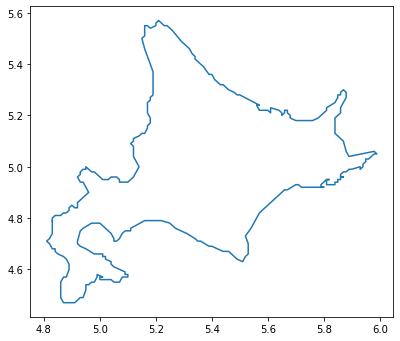

In [ ]:
##
# test code
##
import matplotlib.pyplot as plt

class prfplot:
  def __init__(self, width, points):
    rate = width / 6.51
    self.width = width
    self.height = 5.71 * rate
    self.x = []
    self.y = []
    for i in range(0, len(points), 2):
      if i % 2 == 0:
        self.x.append(points[i] * 0.01 * rate)
        self.y.append((points[i + 1] * -0.01 + 5.71) * rate)

  def prfplot(self):
    return(self.x, self.y)


definition_of_allJapan = [
    {
        "code"       :0,
        "name"       :"日本",
        "english"    :"Japan",
        "color"      :"#a0a0a0",
        "prefectures":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47]
    }
]
alldata = definition_of_allJapan[0]
item = alldata["prefectures"]
print(item)

points=[483,92,483,93,483,95,483,97,482,99,481,100,482,101,483,103,484,103,484,104,485,105,487,106,488,107,489,109,489,110,489,111,488,114,488,114,487,114,486,116,486,119,486,121,486,122,487,124,488,124,490,124,491,124,493,122,494,122,495,119,495,117,496,117,497,116,498,116,499,114,499,113,501,114,500,114,500,115,500,115,501,115,502,115,504,115,505,116,506,116,507,116,508,114,509,114,510,114,510,113,509,113,509,112,507,111,505,110,504,109,504,108,502,107,502,106,501,106,501,105,499,105,498,105,495,103,493,102,492,101,492,100,493,96,494,95,497,93,499,93,500,93,501,94,502,95,502,95,503,96,504,97,505,99,505,99,505,99,505,99,505,100,505,100,506,100,506,100,507,99,508,97,509,96,511,96,511,95,516,92,522,92,525,93,527,95,531,97,534,99,535,100,536,100,539,102,540,102,542,103,544,104,546,104,547,105,549,107,551,108,551,108,552,106,553,105,553,102,553,101,552,98,554,95,556,91,557,89,565,81,566,80,567,80,570,78,571,78,572,79,573,79,575,79,578,79,579,79,580,79,579,79,579,78,581,76,581,76,582,76,582,76,581,76,581,76,581,77,581,77,581,78,583,78,583,78,584,78,584,77,585,77,585,76,586,76,586,75,587,75,586,75,586,74,587,73,587,73,588,73,589,72,590,72,593,71,593,72,593,72,594,71,594,70,594,70,595,69,595,68,596,68,597,67,597,67,598,66,599,66,598,65,589,67,588,65,587,61,586,60,585,59,585,59,584,58,584,57,584,55,584,54,584,53,584,52,586,50,586,48,587,46,588,44,588,43,588,42,587,41,587,41,586,42,586,43,585,43,585,44,584,46,581,48,581,49,580,50,579,51,578,52,576,53,570,53,568,52,568,51,567,50,567,49,566,49,566,50,565,51,565,51,565,50,564,49,561,48,561,48,561,48,561,49,561,50,560,49,558,49,557,49,557,49,556,47,557,47,557,47,550,43,549,43,548,42,546,41,544,39,543,39,541,37,540,35,539,35,537,32,536,31,535,30,535,30,534,29,534,28,533,27,532,25,529,22,526,18,524,16,523,16,522,15,521,14,520,15,520,16,518,17,518,17,517,16,516,16,516,17,516,19,516,20,515,21,516,25,519,34,519,39,519,41,519,43,518,44,518,44,518,45,517,46,517,46,517,50,518,52,518,54,517,55,517,55,517,56,516,58,515,58,514,59,512,60,512,61,511,62,512,63,512,64,512,64,512,65,512,66,512,67,513,69,514,71,512,75,510,77,508,77,507,77,507,76,506,75,506,75,504,75,503,76,502,76,501,76,499,74,499,74,498,73,497,73,495,71,495,72,495,72,494,72,493,73,493,74,492,75,493,77,494,77,495,79,495,79,496,81,495,82,493,84,492,85,492,87,491,87,490,86,489,87,489,88,488,89,487,89,486,90,484,90,483,91,483,91,483,92,483,92]
width = 6.51
height = 5.71
pref = prfplot(width, points)
x, y = pref.prfplot()

print("x:{}".format(x))
print("y:{}".format(y))

plt.rcParams["figure.figsize"] = (width, height)
plt.plot(x,y)
plt.show()

#### NGROK

In [ ]:
!python dldata.py

In [14]:
get_ipython().system_raw('./ngrok http 8000 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
  "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

#!python app.py
! gunicorn app:server


https://60b8a6aa0abb.ngrok.io
[2020-06-17 00:37:20 +0000] [1489] [INFO] Starting gunicorn 20.0.4
[2020-06-17 00:37:20 +0000] [1489] [INFO] Listening at: http://127.0.0.1:8000 (1489)
[2020-06-17 00:37:20 +0000] [1489] [INFO] Using worker: sync
[2020-06-17 00:37:20 +0000] [1492] [INFO] Booting worker with pid: 1492
[2020-06-17 00:39:24 +0000] [1489] [INFO] Handling signal: int
[2020-06-17 00:39:24 +0000] [1492] [INFO] Worker exiting (pid: 1492)
[2020-06-17 00:39:24 +0000] [1489] [INFO] Shutting down: Master


### Nginx

In [ ]:
!wget https://nginx.org/download/nginx-1.18.0.tar.gz
!tar -zxvf nginx-1.18.0.tar.gz

In [ ]:
# lsofコマンドは「LiSt Open Files」（開いているファイル群を列挙する）という言葉に由来します。その名の通り、「プロセスが開いているファイル」を表示するコマンドです。
!sudo lsof -i:80


In [ ]:
!cd nginx-1.18.0
!sudo apt-get install nginx

In [ ]:
!mkdir config

In [ ]:
guni_set = """
import os

# Socket Definition
socket_path = 'unix:/tmp/gunicorn.sock'
bind = socket_path
# bind = '127.0.0.1:' + str(os.getenv('PORT', 9876))
proc_name = 'Infrastructure-Practice-Flask'
workers = 1
"""

with open('./config/gunicorn_settings.py', mode='w', encoding='utf_8_sig') as f:
  f.write(guni_set)

        listen        80;                          # 80番ポートで接続を待つ
        server_name   MY_SERVER;                   # サーバ名はMY_SERVER
        charset       UTF-8;                       # レスポンスヘッダのContent-typeをUTF-8に指定
        error_page    404  /404_not_found.html;    # ステータスコードが404のときに404_not_found.htmlへ内部的にリダイレクト

        # /indexへのアクセスを
        location /index {
            proxy_pass          http://127.0.0.1:9876;  # 127.0.0.1の9876ポートへリバースプロキシする
            proxy_set_header    Host    $host;          # プロキシされたサーバへ渡すリクエストヘッダのうち、Hostに$hostを設定し直す
　　　　　　proxy_read_timeout  60s;                    # プロキシされたサーバからの応答が60秒なかったらタイムアウトとする

In [ ]:
nginxconf = """
worker_processes  1;

events {
    worker_connections 512;
}

http {
    upstream app_server{
        server unix:/tmp/gunicorn.sock;
    }
    server {
        listen        80;
        server_name   appserver;
        charset       UTF-8;
        error_page    404  /404_not_found.html;
        location = /favicon.ico { access_log off; log_not_found off;}

        location /static/ {
            alias /usr/share/nginx/html/static;
        }
    }
}
"""

with open("./config/nginx.conf", mode='w', encoding='utf_8_sig') as f:
  f.write(nginxconf)

Webサーバの起動
アプリケーションサーバの起動

In [ ]:
!nginx -c /content/config/nginx.conf

!gunicorn app:server -c /content/config/gunicorn_settings.py

In [ ]:
!nginx -s stop

In [ ]:
!sudo systemctl start nginx
!sudo systemctl status nginx

In [ ]:
! gunicorn app:server

In [ ]:
!sudo lsof -i | grep nginx

In [ ]:
!sudo kill -9 3675
!sudo kill -9 3676

### Configuration files

In [ ]:
rt = """
Python 3.6.9
"""

with open('runtime.txt', mode='w', encoding='utf_8_sig') as f:
  f.write(rt)

#herokuではruntime.txtでpythonのバージョン指定等runtimeの条件設定ができるがPython3.6.9はサポートされていない

In [ ]:
procf = """
web: bin/start-nginx bundle exec gunicorn --config config/gunicorn.conf.py --app app:server
"""

with open('procfile', mode='w', encoding='utf_8_sig') as f:
  f.write(procf)

In [ ]:
require = """
numpy
pandas
requests
requests-html
seaborn
flask
plotly
dash
dash-html-components
dash-core-components
dash-table
dash-daq 
dash_bootstrap_components
gunicorn
"""

with open('requirements.txt', mode='w', encoding='utf_8_sig') as f:
  f.write(require)

In [ ]:
#config/nginx.confを作成する

conf = """
worker_processes <%= ENV['NGINX_WORKERS'] || 4 %>;

events {
  use epoll;
  accept_mutex on;
  worker_connections 1024;
}

http {
  gzip on;
  gzip_comp_level 3;
  gzip_min_length 150;
  gzip_proxied any;
  gzip_types text/plain text/css text/json text/javascript
    application/javascript application/x-javascript application/json
    application/rss+xml application/vnd.ms-fontobject application/x-font-ttf
    application/xml font/opentype image/svg+xml text/xml;

  server_tokens off;

  log_format l2met 'measure#nginx.service=$request_time request_id=$http_x_request_id';
  access_log logs/nginx/access.log l2met;
  error_log logs/nginx/error.log;

  include mime.types;
  default_type application/octet-stream;
  sendfile on;

  # Must read the body in 5 seconds.
  client_body_timeout 5;

  upstream app_server {
    server unix:/tmp/nginx.socket fail_timeout=0;
  }

  server {
    listen <%= ENV["PORT"] %>;
    server_name _;
    keepalive_timeout 5;

    root /app/public; # path to your app

"""

with open('nginx.conf', mode='w', encoding='utf_8_sig') as f:
  f.write(conf)

### Directory listing for /

下記は静的なwebページの表示はできるが、Dashのような動的なページを表示するのには十分なリソースが無い模様。
!python -m http.server 8000（で、このアプリのフォルダー表示ができる）の代わりに! gunicorn app:serverで表示はできるが、ページ上で動的に表示を変える処理にはリソースが足りない模様。

In [ ]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(8000)"))
!python -m http.server 8000

In [ ]:
from IPython.display import Javascript

def show_port(port, height=400):
  display(Javascript("""
  (async ()=>{
    fm = document.createElement('iframe')
    fm.src = await google.colab.kernel.proxyPort(%s)
    fm.width = '95%%'
    fm.height = '%d'
    fm.frameBorder = 0
    document.body.append(fm)
  })();
  """ % (port, height) ))
get_ipython().system_raw('python3 -m http.server 8888 &') 
show_port(8888)

In [ ]:
# To stop the server, you can call ps and kill the process.
!ps